# **EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [3]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,7,0,0,6,0,1,28,0,6,1,...,0,16,0,0,6,2,4,47,36,rrna_chunk
2467,1,0,0,12,0,0,77,0,10,0,...,0,81,0,0,0,2,0,18,13,rrna_chunk
2380,0,0,0,3,0,0,51,0,7,0,...,0,1,0,6,1,0,0,10,23,rrna_chunk
2293,0,0,0,2,0,0,27,0,12,0,...,0,54,0,0,0,1,0,8,0,rrna_chunk
2283,8,0,0,5,0,3,59,0,0,0,...,0,3,0,0,0,0,0,18,34,rrna_chunk
2428,0,0,0,5,0,1,26,0,10,0,...,0,8,0,0,0,0,0,46,24,rrna_chunk
2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,2,13,0,0,16,7,rrna_chunk
2267,0,0,0,5,0,0,81,1,3,0,...,0,7,0,1,3,0,0,2,3,rrna_chunk


Dissociated Bulks:

In [4]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,3,0,0,2,0,0,15,0,1,0,...,0,19,0,1,1,3,4,39,28,rrna_diss
2467,1,0,0,5,0,0,63,1,6,0,...,0,27,0,0,0,0,0,8,6,rrna_diss
2380,4,0,0,2,0,0,37,0,2,0,...,0,2,0,0,0,0,0,10,21,rrna_diss
2293,2,0,0,4,0,0,31,0,3,0,...,0,6,0,0,6,0,0,6,2,rrna_diss
2283,1,0,0,1,0,0,33,0,2,0,...,0,6,0,0,1,0,0,20,16,rrna_diss
2428,3,2,0,1,0,0,7,0,5,0,...,0,17,0,0,2,0,0,57,30,rrna_diss
2251,8,0,0,1,0,1,38,0,0,0,...,0,4,0,0,4,0,0,10,9,rrna_diss
2267,1,0,0,1,0,0,26,0,5,0,...,0,19,0,2,11,0,1,15,3,rrna_diss


Dissociated polyA:

In [5]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,17,2,0,10,0,2,66,0,15,1,...,1,35,0,0,9,9,7,56,78,polyA_diss
2467,2,1,0,7,0,3,134,0,8,0,...,4,58,0,1,2,0,0,15,11,polyA_diss
2380,5,1,0,6,0,0,159,0,16,0,...,0,2,0,2,6,0,0,27,32,polyA_diss
2293,4,0,0,13,0,4,92,0,5,0,...,0,16,0,0,1,0,0,4,6,polyA_diss
2283,7,0,0,11,0,9,114,0,12,0,...,0,9,0,0,1,0,0,10,17,polyA_diss
2428,0,0,0,1,0,0,14,0,10,0,...,0,35,0,0,6,0,0,51,27,polyA_diss
2251,2,0,0,6,0,1,93,0,9,1,...,0,6,0,2,16,0,0,10,12,polyA_diss
2267,0,0,0,5,0,1,69,0,12,0,...,1,33,0,4,30,0,0,6,3,polyA_diss


And all single-cells:

In [6]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [7]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [8]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [9]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

And final formatting on the bulks:

In [10]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [11]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,7,0,0,6,0,1,28,0,6,1,...,0,16,0,0,6,2,4,47,36,rrna_chunk
2467,1,0,0,12,0,0,77,0,10,0,...,0,81,0,0,0,2,0,18,13,rrna_chunk
2380,0,0,0,3,0,0,51,0,7,0,...,0,1,0,6,1,0,0,10,23,rrna_chunk
2293,0,0,0,2,0,0,27,0,12,0,...,0,54,0,0,0,1,0,8,0,rrna_chunk
2283,8,0,0,5,0,3,59,0,0,0,...,0,3,0,0,0,0,0,18,34,rrna_chunk
2428,0,0,0,5,0,1,26,0,10,0,...,0,8,0,0,0,0,0,46,24,rrna_chunk
2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,2,13,0,0,16,7,rrna_chunk
2267,0,0,0,5,0,0,81,1,3,0,...,0,7,0,1,3,0,0,2,3,rrna_chunk


Assigning genes: 

In [12]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Defining gene markers:

In [13]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [14]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_93164/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adip_markers = np.array(adip_markers)


In [15]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [16]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids

array(['A1BG', 'A2M', 'AAGAB', ..., 'ZSCAN18', 'ZXDC', 'ZYX'],
      dtype=object)

In [17]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [18]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.030055,1.0,0.204150,0.326818,0.074803,1.0,0.225522,0.043635,0.517387,0.343737,...,0.120442,0.272051,0.069460,0.049201,0.163854,0.292533,0.047642,0.480654,0.397613,1.000000
2467,0.033547,1.0,0.220404,0.264924,0.285929,1.0,0.332957,0.010033,0.813582,0.516679,...,0.091548,0.326060,0.089666,0.037622,0.220090,0.316027,0.070542,0.276210,0.763419,0.679082
2380,0.006216,1.0,0.206199,0.726840,0.059802,1.0,0.402323,0.105672,0.304583,0.754491,...,0.066232,0.146183,0.058087,0.081022,0.182192,0.461697,0.038368,0.124748,0.202341,0.739915
2293,0.017206,1.0,0.333671,0.077598,0.049933,1.0,0.228070,0.031377,1.000000,0.645412,...,0.140688,0.289811,0.109312,0.067139,0.059379,0.281714,0.111336,0.128543,0.534076,0.741903
2283,0.073468,1.0,0.313709,0.229955,0.078856,1.0,0.267179,0.097223,0.847088,0.300485,...,0.092815,0.348974,0.089141,0.088897,0.275751,0.421952,0.088162,0.743498,0.506196,0.329137
2428,0.036162,1.0,0.200212,0.084671,0.174634,1.0,1.000000,0.018081,1.000000,0.458194,...,0.121715,0.164932,0.097901,0.053360,0.397777,0.300318,0.030429,0.427765,0.802611,0.248280
2251,0.020254,1.0,0.181786,0.377576,0.075515,1.0,0.382326,0.080266,0.407832,0.329816,...,0.122525,0.201790,0.075765,0.048510,0.091018,0.230296,0.112022,0.254301,0.450340,0.836167
2267,0.007659,1.0,0.244241,0.285090,0.089357,1.0,0.270339,0.108079,0.257574,0.609611,...,0.093044,0.172189,0.050210,0.070918,0.139283,0.446216,0.085102,0.145524,0.249064,1.000000
2497,0.040802,1.0,0.173564,0.440537,0.132762,1.0,0.162379,0.107079,0.409884,0.330351,...,0.113086,0.316267,0.059442,0.071869,0.118264,0.399735,0.043494,0.489623,0.342364,1.000000
2467,0.028365,1.0,0.153033,0.383807,0.145328,1.0,0.296960,0.100854,0.337932,0.435285,...,0.083345,0.258440,0.076341,0.053579,0.109259,0.235327,0.090349,0.210464,0.411822,0.980529


In [19]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.030055,1.0,0.204150,0.326818,0.074803,1.0,0.225522,0.043635,0.517387,0.343737,...,0.120442,0.272051,0.069460,0.049201,0.163854,0.292533,0.047642,0.480654,0.397613,1.000000
2467,0.033547,1.0,0.220404,0.264924,0.285929,1.0,0.332957,0.010033,0.813582,0.516679,...,0.091548,0.326060,0.089666,0.037622,0.220090,0.316027,0.070542,0.276210,0.763419,0.679082
2380,0.006216,1.0,0.206199,0.726840,0.059802,1.0,0.402323,0.105672,0.304583,0.754491,...,0.066232,0.146183,0.058087,0.081022,0.182192,0.461697,0.038368,0.124748,0.202341,0.739915
2293,0.017206,1.0,0.333671,0.077598,0.049933,1.0,0.228070,0.031377,1.000000,0.645412,...,0.140688,0.289811,0.109312,0.067139,0.059379,0.281714,0.111336,0.128543,0.534076,0.741903
2283,0.073468,1.0,0.313709,0.229955,0.078856,1.0,0.267179,0.097223,0.847088,0.300485,...,0.092815,0.348974,0.089141,0.088897,0.275751,0.421952,0.088162,0.743498,0.506196,0.329137
2428,0.036162,1.0,0.200212,0.084671,0.174634,1.0,1.000000,0.018081,1.000000,0.458194,...,0.121715,0.164932,0.097901,0.053360,0.397777,0.300318,0.030429,0.427765,0.802611,0.248280
2251,0.020254,1.0,0.181786,0.377576,0.075515,1.0,0.382326,0.080266,0.407832,0.329816,...,0.122525,0.201790,0.075765,0.048510,0.091018,0.230296,0.112022,0.254301,0.450340,0.836167
2267,0.007659,1.0,0.244241,0.285090,0.089357,1.0,0.270339,0.108079,0.257574,0.609611,...,0.093044,0.172189,0.050210,0.070918,0.139283,0.446216,0.085102,0.145524,0.249064,1.000000


In [20]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.040802,1.0,0.173564,0.440537,0.132762,1.0,0.162379,0.107079,0.409884,0.330351,...,0.113086,0.316267,0.059442,0.071869,0.118264,0.399735,0.043494,0.489623,0.342364,1.000000
2467,0.028365,1.0,0.153033,0.383807,0.145328,1.0,0.296960,0.100854,0.337932,0.435285,...,0.083345,0.258440,0.076341,0.053579,0.109259,0.235327,0.090349,0.210464,0.411822,0.980529
2380,0.021970,1.0,0.192102,0.426267,0.360894,1.0,0.246222,0.142268,0.451988,0.378041,...,0.144679,0.223449,0.054389,0.108777,0.191298,0.571750,0.049566,0.153788,0.329547,1.000000
2293,0.013237,1.0,0.293696,0.410623,0.105896,1.0,0.146986,0.083007,0.377806,0.498042,...,0.229993,0.265843,0.071976,0.101484,0.211516,0.702112,0.124924,0.217032,0.377254,1.000000
2283,0.043453,1.0,0.210692,0.306461,0.131504,1.0,0.158090,0.116352,0.391366,0.268439,...,0.079760,0.307890,0.068325,0.152373,0.274157,0.806175,0.075186,0.457690,0.565180,0.689251
2428,0.068473,1.0,0.193271,0.180018,0.668532,1.0,0.498822,0.082462,0.655279,0.350464,...,0.143941,0.210573,0.041599,0.119276,0.174128,0.705713,0.027242,0.344942,0.748049,0.603004
2251,0.017560,1.0,0.169566,0.449706,0.183834,1.0,0.256544,0.290567,0.305932,0.426933,...,0.189596,0.207979,0.039785,0.081216,0.137464,0.587719,0.072985,0.262855,0.435164,0.855787
2267,0.022028,1.0,0.186070,0.157246,0.059524,1.0,0.138733,0.092098,0.258015,0.342145,...,0.092567,0.220988,0.058821,0.070538,0.017576,0.483221,0.122563,0.086005,0.270669,1.000000


In [21]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.022610,1.0,0.167152,0.487799,0.059249,0.712036,0.169689,0.084695,0.269010,0.285949,...,0.052608,0.296097,0.057235,0.037908,0.079024,0.385344,0.062085,0.473547,0.304156,1.0
2467,0.028222,1.0,0.167387,0.434038,0.099264,1.000000,0.238624,0.076687,0.147145,0.406205,...,0.038927,0.341391,0.088559,0.050411,0.066176,0.237066,0.180038,0.247966,0.368446,1.0
2380,0.010450,1.0,0.202332,0.489776,0.071893,1.000000,0.252820,0.106769,0.303057,0.338814,...,0.106013,0.235067,0.057287,0.052881,0.107650,0.613165,0.106139,0.117974,0.252694,1.0
2293,0.006917,1.0,0.295030,0.470569,0.046747,1.000000,0.118060,0.065112,0.246613,0.394247,...,0.100410,0.293360,0.057956,0.062965,0.177447,0.659702,0.190565,0.224432,0.298846,1.0
2283,0.016287,1.0,0.207603,0.343669,0.052571,0.870202,0.163279,0.108234,0.252134,0.246774,...,0.044943,0.331505,0.068857,0.061848,0.239558,0.718055,0.118336,0.425308,0.468602,1.0
2428,0.028983,1.0,0.200763,0.154107,0.158584,1.000000,0.324002,0.076347,0.357227,0.320939,...,0.084594,0.249069,0.061266,0.062208,0.109100,0.731420,0.034167,0.294076,0.712333,1.0
2251,0.009185,1.0,0.142781,0.471594,0.067800,1.000000,0.239137,0.231455,0.190708,0.379079,...,0.088674,0.205571,0.042751,0.039411,0.100030,0.565946,0.100865,0.233459,0.356201,1.0
2267,0.012037,1.0,0.195039,0.167301,0.036286,1.000000,0.155089,0.068037,0.183699,0.265692,...,0.043962,0.241094,0.065245,0.038729,0.010642,0.460905,0.200098,0.084784,0.218764,1.0


As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [22]:
Counter(merged_adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [23]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Mast cells", "Erythroid", "Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Fibroblasts' 'ILC'
 'Macrophages' 'Monocytes' 'NK cells' 'Plasma cells' 'T cells' 'pDC']


## References

In [24]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,3176.691162,2728.264648,4269.930176,1696.864868,5429.107910,4638.094727,4298.012207,4591.973145,3643.295166,3066.527344,3316.777588,14280.144531
A2M,6174.165039,1471.580688,1790.907715,92142.218750,1621.545288,4215.951172,2486.045654,28022.445312,850.147217,4348.663086,11753.244141,581.640015
AAGAB,1532.644165,2969.210938,1351.539551,1520.916504,1862.004150,1343.927490,2045.564453,1429.618042,2913.262207,874.592468,2981.855713,731.273987
AASS,1037.645264,447.346252,330.150116,2270.679688,208.211868,581.486755,757.800537,4443.779785,761.770874,0.000000,333.871643,61.586510
AATK,180.999893,2595.554199,112.723755,650.765564,302.796875,987.640259,460.832764,1283.115112,0.000000,584.397827,1271.838379,589.161316
...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,1209.184326,1490.130615,2959.224365,2362.965332,2243.838623,2712.817871,3140.357178,2245.082520,2363.349121,1662.900513,1987.893066,3782.451660
ZRSR2,1637.513428,2043.510742,5659.712402,2058.617676,5526.329102,1479.814941,3767.974121,2848.099854,5869.167969,2208.777832,3217.734863,1101.340210
ZSCAN18,450.007629,489.025177,823.832031,2347.856201,1595.420166,3574.088867,3519.722412,2704.987793,2830.763428,417.875854,414.410828,415.006012
ZXDC,2888.988770,2165.231201,1807.674805,1364.342041,2144.659180,2399.813965,1651.087646,1252.304199,1752.973389,1631.230225,1663.477295,1574.842041


In [25]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,0.352452,0.302699,0.473746,0.188266,0.602356,0.514593,0.476861,0.509476,0.404221,0.340229,0.367994,1.000000
A2M,0.685019,0.163271,0.198700,1.000000,0.179909,0.467757,0.275825,1.000000,0.094323,0.482481,1.000000,0.064533
AAGAB,0.170046,0.329432,0.149952,0.168745,0.206588,0.149108,0.226954,0.158615,0.323224,0.097035,0.330835,0.081134
AASS,0.115126,0.049633,0.036630,0.251930,0.023101,0.064516,0.084077,0.493034,0.084518,0.000000,0.037043,0.006833
AATK,0.020082,0.287975,0.012507,0.072202,0.033595,0.109578,0.051129,0.142361,0.000000,0.064839,0.141110,0.065367
...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,0.134158,0.165329,0.328324,0.262169,0.248952,0.300985,0.348420,0.249090,0.262212,0.184498,0.220555,0.419660
ZRSR2,0.181681,0.226726,0.627941,0.228402,0.613142,0.164184,0.418054,0.315995,0.651180,0.245062,0.357005,0.122193
ZSCAN18,0.049928,0.054257,0.091404,0.260493,0.177011,0.396543,0.390511,0.300116,0.314071,0.046363,0.045979,0.046045
ZXDC,0.320531,0.240231,0.200560,0.151373,0.237948,0.266258,0.183187,0.138942,0.194491,0.180984,0.184562,0.174728


## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [31]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [32]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [33]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [34]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
2497,0.186322,0.000000,0.000000,0.022077,0.000000,0.291796,0.017030,0.421096,0.005746,0.0,0.055934,0.0
2467,0.213313,0.000000,0.000000,0.011625,0.000000,0.543663,0.028069,0.106225,0.000000,0.0,0.097106,0.0
2380,0.061187,0.094452,0.000000,0.292666,0.000000,0.000000,0.000000,0.481944,0.000000,0.0,0.069751,0.0
2293,0.132102,0.000000,0.000000,0.002300,0.006893,0.379892,0.003239,0.000000,0.009617,0.0,0.465957,0.0
2283,0.159333,0.000000,0.000000,0.084801,0.000000,0.446144,0.000000,0.249584,0.000000,0.0,0.060137,0.0
2428,0.237395,0.000000,0.000000,0.011794,0.000000,0.504556,0.018662,0.087854,0.060006,0.0,0.079733,0.0
2251,0.325851,0.000000,0.000000,0.011099,0.000000,0.000000,0.000000,0.379682,0.032997,0.0,0.250370,0.0
2267,0.083423,0.148000,0.000000,0.236888,0.000000,0.000000,0.000000,0.343630,0.000000,0.0,0.188060,0.0
2497,0.189246,0.000000,0.000000,0.126376,0.000000,0.203272,0.000000,0.464760,0.000000,0.0,0.016346,0.0
2467,0.243812,0.000000,0.000000,0.140939,0.000000,0.000802,0.000000,0.354080,0.000000,0.0,0.260366,0.0


## Evalutating NNLS Performance:

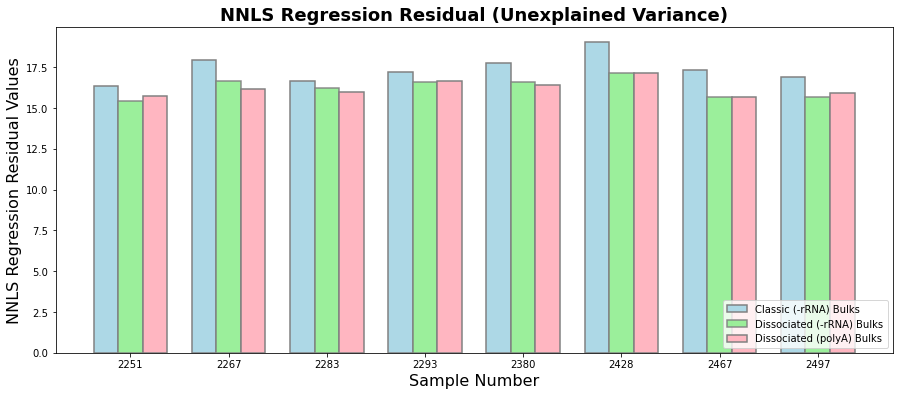

In [35]:

# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

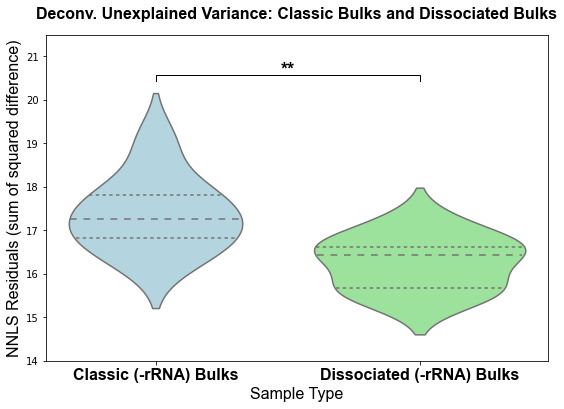

In [36]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

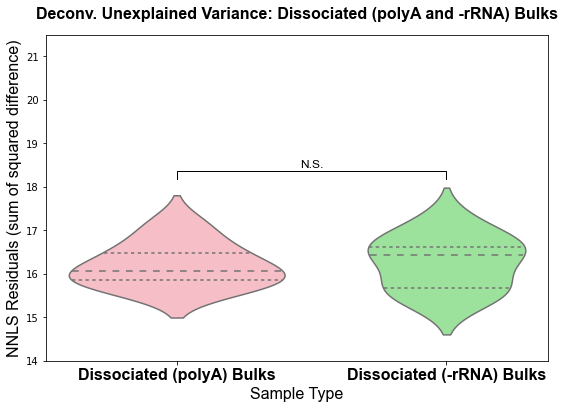

In [37]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', 
                palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, 
                fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, 
                    fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [38]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.465547,0.768470,0.169937,0.257442,0.106021,0.844144,0.192238,0.078104,0.353109,0.474803,...,0.188874,0.936766,0.285176,0.406997,0.201392,0.243278,0.250696,0.268167,0.213825,0.767947
2467,0.460375,0.623123,0.174644,0.120891,0.094956,0.730286,0.148486,0.066683,0.365557,0.513295,...,0.181368,0.929610,0.266110,0.431486,0.174963,0.252956,0.210639,0.276570,0.252711,0.767284
2380,0.376462,0.901696,0.190426,0.325662,0.128012,0.873917,0.183625,0.241069,0.317310,0.501355,...,0.193474,0.981101,0.272532,0.409587,0.183071,0.235984,0.276570,0.232264,0.166440,0.887019
2293,0.423536,0.739487,0.238919,0.058802,0.110595,0.811822,0.163806,0.044289,0.309751,0.449351,...,0.189924,0.948819,0.230346,0.387631,0.128241,0.240803,0.265090,0.184768,0.233942,0.860960
2283,0.450993,0.712356,0.167411,0.193772,0.102227,0.758302,0.150699,0.098847,0.360918,0.527919,...,0.171997,0.952126,0.283254,0.439661,0.189081,0.253323,0.221903,0.284630,0.228474,0.812960
2428,0.452788,0.588818,0.181536,0.115763,0.085619,0.719253,0.163689,0.070915,0.371688,0.501676,...,0.201153,0.886073,0.260919,0.421014,0.167398,0.248510,0.231767,0.271169,0.254231,0.711709
2251,0.415848,0.867479,0.211003,0.239570,0.096727,0.976594,0.261938,0.082671,0.366445,0.374643,...,0.210811,0.879439,0.223087,0.332765,0.174551,0.205073,0.292584,0.154984,0.211506,0.670157
2267,0.363076,0.849888,0.219637,0.253016,0.136856,0.897947,0.185162,0.201826,0.297123,0.456530,...,0.190991,0.973207,0.240696,0.378918,0.154439,0.224838,0.278541,0.185678,0.180605,0.887430


In [39]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.437894,0.832201,0.162941,0.296487,0.103669,0.852079,0.194820,0.140062,0.367281,0.494969,...,0.184825,0.943746,0.283630,0.415265,0.207206,0.239075,0.249318,0.263208,0.201504,0.777940
2467,0.389088,0.922777,0.207662,0.247846,0.102307,0.938914,0.231687,0.156329,0.358051,0.428557,...,0.201704,0.924886,0.230249,0.364249,0.172248,0.215524,0.281458,0.167441,0.196948,0.761163
2380,0.375594,0.876443,0.190023,0.304111,0.119460,0.889849,0.199079,0.224323,0.338751,0.478569,...,0.193775,0.955126,0.255069,0.394236,0.181536,0.225741,0.268146,0.213271,0.181487,0.823811
2293,0.386872,0.773573,0.204020,0.165280,0.101034,0.804847,0.178760,0.189581,0.346584,0.490459,...,0.209405,0.934268,0.235024,0.403865,0.154386,0.236464,0.252793,0.210582,0.216117,0.796401
2283,0.439405,0.753690,0.165218,0.226374,0.098810,0.795140,0.171874,0.122676,0.372882,0.512665,...,0.178055,0.939947,0.275819,0.427272,0.194551,0.244141,0.228809,0.269046,0.222310,0.778733
2428,0.417175,0.728187,0.177473,0.165720,0.088493,0.796798,0.180777,0.126800,0.391808,0.493962,...,0.181099,0.914018,0.242712,0.411165,0.176724,0.232353,0.220546,0.230941,0.240419,0.729602
2251,0.331619,0.880580,0.182189,0.235411,0.076723,0.854542,0.220097,0.295312,0.421956,0.494559,...,0.206128,0.894291,0.208200,0.395609,0.172213,0.209660,0.241511,0.174547,0.212161,0.687541
2267,0.394783,0.866995,0.247487,0.142113,0.104115,0.902562,0.236613,0.120475,0.297786,0.372849,...,0.230646,0.938714,0.223160,0.349210,0.123779,0.218939,0.334972,0.108312,0.203033,0.805701


In [40]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.441282,0.836509,0.161986,0.303192,0.108763,0.830686,0.180008,0.146995,0.353676,0.515038,...,0.183124,0.961709,0.296711,0.429183,0.207937,0.247774,0.251439,0.280546,0.194232,0.821940
2467,0.389542,0.944203,0.212073,0.261111,0.117434,0.896608,0.197302,0.178949,0.318213,0.470967,...,0.199244,0.970890,0.257007,0.392759,0.168698,0.234666,0.291852,0.199073,0.176170,0.877946
2380,0.364086,0.874038,0.197194,0.295058,0.126269,0.873762,0.185192,0.242932,0.322277,0.490699,...,0.193259,0.970015,0.255638,0.400517,0.172823,0.229647,0.270615,0.213811,0.175876,0.867012
2293,0.392993,0.747112,0.202478,0.161464,0.109782,0.776105,0.156135,0.181096,0.330939,0.510821,...,0.198542,0.954750,0.248184,0.418685,0.153790,0.244894,0.246742,0.230767,0.214306,0.846461
2283,0.445636,0.762283,0.165005,0.236324,0.107592,0.764206,0.148958,0.130158,0.349389,0.542018,...,0.175404,0.969082,0.296437,0.447939,0.195149,0.257834,0.233546,0.295169,0.210393,0.850521
2428,0.417603,0.716105,0.179799,0.149459,0.093127,0.756832,0.157122,0.133845,0.376155,0.521556,...,0.178153,0.934351,0.253110,0.429642,0.171295,0.243383,0.218848,0.248340,0.237166,0.784638
2251,0.320097,0.897868,0.177252,0.253370,0.079298,0.820656,0.202573,0.341674,0.414913,0.531307,...,0.206978,0.913153,0.220529,0.417545,0.173627,0.218542,0.241446,0.194483,0.200626,0.733815
2267,0.404128,0.887154,0.251102,0.150796,0.114502,0.906268,0.219175,0.121366,0.286306,0.391398,...,0.227085,0.958408,0.230305,0.360919,0.128300,0.224816,0.328757,0.131247,0.196282,0.865445


In [41]:
calc_prop_tot_combo

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
2497,0.186322,0.000000,0.000000,0.022077,0.000000,0.291796,0.017030,0.421096,0.005746,0.0,0.055934,0.0
2467,0.213313,0.000000,0.000000,0.011625,0.000000,0.543663,0.028069,0.106225,0.000000,0.0,0.097106,0.0
2380,0.061187,0.094452,0.000000,0.292666,0.000000,0.000000,0.000000,0.481944,0.000000,0.0,0.069751,0.0
2293,0.132102,0.000000,0.000000,0.002300,0.006893,0.379892,0.003239,0.000000,0.009617,0.0,0.465957,0.0
2283,0.159333,0.000000,0.000000,0.084801,0.000000,0.446144,0.000000,0.249584,0.000000,0.0,0.060137,0.0
2428,0.237395,0.000000,0.000000,0.011794,0.000000,0.504556,0.018662,0.087854,0.060006,0.0,0.079733,0.0
2251,0.325851,0.000000,0.000000,0.011099,0.000000,0.000000,0.000000,0.379682,0.032997,0.0,0.250370,0.0
2267,0.083423,0.148000,0.000000,0.236888,0.000000,0.000000,0.000000,0.343630,0.000000,0.0,0.188060,0.0
2497,0.189246,0.000000,0.000000,0.126376,0.000000,0.203272,0.000000,0.464760,0.000000,0.0,0.016346,0.0
2467,0.243812,0.000000,0.000000,0.140939,0.000000,0.000802,0.000000,0.354080,0.000000,0.0,0.260366,0.0


In [42]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,0.465547,0.768470,0.169937,0.257442,0.106021,0.844144,0.192238,0.078104,0.353109,0.474803,...,0.188874,0.936766,0.285176,0.406997,0.201392,0.243278,0.250696,0.268167,0.213825,0.767947
2467,0.460375,0.623123,0.174644,0.120891,0.094956,0.730286,0.148486,0.066683,0.365557,0.513295,...,0.181368,0.929610,0.266110,0.431486,0.174963,0.252956,0.210639,0.276570,0.252711,0.767284
2380,0.376462,0.901696,0.190426,0.325662,0.128012,0.873917,0.183625,0.241069,0.317310,0.501355,...,0.193474,0.981101,0.272532,0.409587,0.183071,0.235984,0.276570,0.232264,0.166440,0.887019
2293,0.423536,0.739487,0.238919,0.058802,0.110595,0.811822,0.163806,0.044289,0.309751,0.449351,...,0.189924,0.948819,0.230346,0.387631,0.128241,0.240803,0.265090,0.184768,0.233942,0.860960
2283,0.450993,0.712356,0.167411,0.193772,0.102227,0.758302,0.150699,0.098847,0.360918,0.527919,...,0.171997,0.952126,0.283254,0.439661,0.189081,0.253323,0.221903,0.284630,0.228474,0.812960
2428,0.452788,0.588818,0.181536,0.115763,0.085619,0.719253,0.163689,0.070915,0.371688,0.501676,...,0.201153,0.886073,0.260919,0.421014,0.167398,0.248510,0.231767,0.271169,0.254231,0.711709
2251,0.415848,0.867479,0.211003,0.239570,0.096727,0.976594,0.261938,0.082671,0.366445,0.374643,...,0.210811,0.879439,0.223087,0.332765,0.174551,0.205073,0.292584,0.154984,0.211506,0.670157
2267,0.363076,0.849888,0.219637,0.253016,0.136856,0.897947,0.185162,0.201826,0.297123,0.456530,...,0.190991,0.973207,0.240696,0.378918,0.154439,0.224838,0.278541,0.185678,0.180605,0.887430
2497,0.437894,0.832201,0.162941,0.296487,0.103669,0.852079,0.194820,0.140062,0.367281,0.494969,...,0.184825,0.943746,0.283630,0.415265,0.207206,0.239075,0.249318,0.263208,0.201504,0.777940
2467,0.389088,0.922777,0.207662,0.247846,0.102307,0.938914,0.231687,0.156329,0.358051,0.428557,...,0.201704,0.924886,0.230249,0.364249,0.172248,0.215524,0.281458,0.167441,0.196948,0.761163


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [43]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,-0.435492,0.231530,0.034213,0.069376,-0.031218,0.155856,0.033284,-0.034469,0.164279,-0.131066,...,-0.068433,-0.664715,-0.215716,-0.357796,-0.037538,0.049255,-0.203053,0.212486,0.183788,0.232053
2467,-0.426828,0.376877,0.045760,0.144033,0.190973,0.269714,0.184471,-0.056651,0.448025,0.003384,...,-0.089821,-0.603550,-0.176444,-0.393863,0.045128,0.063071,-0.140097,-0.000360,0.510708,-0.088202
2380,-0.370246,0.098304,0.015773,0.401178,-0.068210,0.126083,0.218699,-0.135398,-0.012727,0.253135,...,-0.127242,-0.834918,-0.214445,-0.328565,-0.000878,0.225713,-0.238202,-0.107515,0.035901,-0.147104
2293,-0.406329,0.260513,0.094752,0.018796,-0.060662,0.188178,0.064265,-0.012913,0.690249,0.196061,...,-0.049236,-0.659008,-0.121034,-0.320492,-0.068862,0.040911,-0.153754,-0.056225,0.300134,-0.119057
2283,-0.377524,0.287644,0.146299,0.036183,-0.023371,0.241698,0.116481,-0.001624,0.486171,-0.227434,...,-0.079182,-0.603152,-0.194113,-0.350764,0.086670,0.168629,-0.133741,0.458868,0.277722,-0.483822
2428,-0.416626,0.411182,0.018676,-0.031091,0.089015,0.280747,0.836311,-0.052834,0.628312,-0.043482,...,-0.079439,-0.721141,-0.163018,-0.367654,0.230379,0.051808,-0.201338,0.156596,0.548379,-0.463429
2251,-0.395594,0.132521,-0.029216,0.138006,-0.021211,0.023406,0.120389,-0.002405,0.041387,-0.044827,...,-0.088286,-0.677649,-0.147322,-0.284255,-0.083533,0.025223,-0.180562,0.099317,0.238834,0.166010
2267,-0.355417,0.150112,0.024605,0.032074,-0.047499,0.102053,0.085177,-0.093747,-0.039549,0.153081,...,-0.097947,-0.801018,-0.190487,-0.308000,-0.015156,0.221378,-0.193439,-0.040155,0.068458,0.112570


In [44]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,-0.397092,0.167799,0.010623,0.144050,0.029092,0.147921,-0.032441,-0.032983,0.042602,-0.164618,...,-0.071740,-0.627479,-0.224188,-0.343395,-0.088942,0.160660,-0.205824,0.226415,0.140860,0.222060
2467,-0.360722,0.077223,-0.054630,0.135961,0.043021,0.061086,0.065274,-0.055474,-0.020118,0.006728,...,-0.118359,-0.666446,-0.153908,-0.310670,-0.062989,0.019803,-0.191109,0.043022,0.214875,0.219367
2380,-0.353625,0.123557,0.002079,0.122157,0.241434,0.110151,0.047144,-0.082055,0.113237,-0.100528,...,-0.049096,-0.731677,-0.200680,-0.285458,0.009762,0.346009,-0.218580,-0.059483,0.148060,0.176189
2293,-0.373635,0.226427,0.089676,0.245343,0.004862,0.195153,-0.031774,-0.106574,0.031222,0.007583,...,0.020588,-0.668425,-0.163048,-0.302382,0.057130,0.465648,-0.127869,0.006449,0.161138,0.203599
2283,-0.395951,0.246310,0.045474,0.080087,0.032693,0.204860,-0.013784,-0.006324,0.018485,-0.244226,...,-0.098296,-0.632057,-0.207494,-0.274899,0.079606,0.562034,-0.153623,0.188644,0.342870,-0.089482
2428,-0.348702,0.271813,0.015797,0.014298,0.580039,0.203202,0.318045,-0.044338,0.263471,-0.143499,...,-0.037158,-0.703445,-0.201113,-0.291890,-0.002596,0.473360,-0.193304,0.114001,0.507630,-0.126598
2251,-0.314059,0.119420,-0.012623,0.214295,0.107111,0.145458,0.036447,-0.004746,-0.116024,-0.067626,...,-0.016532,-0.686312,-0.168416,-0.314393,-0.034750,0.378058,-0.168527,0.088308,0.223003,0.168246
2267,-0.372754,0.133005,-0.061417,0.015133,-0.044592,0.097438,-0.097880,-0.028377,-0.039771,-0.030704,...,-0.138080,-0.717726,-0.164340,-0.278672,-0.106203,0.264282,-0.212410,-0.022307,0.067637,0.194299


In [45]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,-0.418671,0.163491,0.005166,0.184607,-0.049514,-0.118650,-0.010319,-0.062300,-0.084666,-0.229089,...,-0.130516,-0.665612,-0.239477,-0.391276,-0.128913,0.137571,-0.189354,0.193001,0.109924,0.178060
2467,-0.361320,0.055797,-0.044687,0.172927,-0.018170,0.103392,0.041321,-0.102262,-0.171069,-0.064762,...,-0.160316,-0.629499,-0.168448,-0.342348,-0.102522,0.002400,-0.111814,0.048893,0.192275,0.122054
2380,-0.353635,0.125962,0.005138,0.194719,-0.054377,0.126238,0.067629,-0.136163,-0.019220,-0.151884,...,-0.087246,-0.734947,-0.198350,-0.347637,-0.065173,0.383517,-0.164476,-0.095836,0.076818,0.132988
2293,-0.386077,0.252888,0.092551,0.309105,-0.063035,0.223895,-0.038075,-0.115985,-0.084326,-0.116574,...,-0.098132,-0.661390,-0.190228,-0.355720,0.023657,0.414808,-0.056178,-0.006335,0.084539,0.153539
2283,-0.429350,0.237717,0.042598,0.107345,-0.055021,0.105995,0.014321,-0.021924,-0.097255,-0.295244,...,-0.130461,-0.637576,-0.227579,-0.386091,0.044409,0.460221,-0.115210,0.130139,0.258209,0.149479
2428,-0.388619,0.283895,0.020964,0.004648,0.065457,0.243168,0.166880,-0.057498,-0.018928,-0.200617,...,-0.093559,-0.685282,-0.191845,-0.367433,-0.062195,0.488037,-0.184680,0.045736,0.475167,0.215362
2251,-0.310912,0.102132,-0.034472,0.218224,-0.011498,0.179344,0.036564,-0.110219,-0.224204,-0.152228,...,-0.118303,-0.707582,-0.177778,-0.378134,-0.073597,0.347404,-0.140581,0.038976,0.155575,0.266185
2267,-0.392091,0.112846,-0.056064,0.016504,-0.078215,0.093732,-0.064087,-0.053330,-0.102607,-0.125706,...,-0.183123,-0.717314,-0.165060,-0.322190,-0.117659,0.236089,-0.128660,-0.046463,0.022482,0.134555


In [46]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
2497,-0.435492,0.231530,0.034213,0.069376,-0.031218,0.155856,0.033284,-0.034469,0.164279,-0.131066,...,-0.068433,-0.664715,-0.215716,-0.357796,-0.037538,0.049255,-0.203053,0.212486,0.183788,0.232053
2467,-0.426828,0.376877,0.045760,0.144033,0.190973,0.269714,0.184471,-0.056651,0.448025,0.003384,...,-0.089821,-0.603550,-0.176444,-0.393863,0.045128,0.063071,-0.140097,-0.000360,0.510708,-0.088202
2380,-0.370246,0.098304,0.015773,0.401178,-0.068210,0.126083,0.218699,-0.135398,-0.012727,0.253135,...,-0.127242,-0.834918,-0.214445,-0.328565,-0.000878,0.225713,-0.238202,-0.107515,0.035901,-0.147104
2293,-0.406329,0.260513,0.094752,0.018796,-0.060662,0.188178,0.064265,-0.012913,0.690249,0.196061,...,-0.049236,-0.659008,-0.121034,-0.320492,-0.068862,0.040911,-0.153754,-0.056225,0.300134,-0.119057
2283,-0.377524,0.287644,0.146299,0.036183,-0.023371,0.241698,0.116481,-0.001624,0.486171,-0.227434,...,-0.079182,-0.603152,-0.194113,-0.350764,0.086670,0.168629,-0.133741,0.458868,0.277722,-0.483822
2428,-0.416626,0.411182,0.018676,-0.031091,0.089015,0.280747,0.836311,-0.052834,0.628312,-0.043482,...,-0.079439,-0.721141,-0.163018,-0.367654,0.230379,0.051808,-0.201338,0.156596,0.548379,-0.463429
2251,-0.395594,0.132521,-0.029216,0.138006,-0.021211,0.023406,0.120389,-0.002405,0.041387,-0.044827,...,-0.088286,-0.677649,-0.147322,-0.284255,-0.083533,0.025223,-0.180562,0.099317,0.238834,0.166010
2267,-0.355417,0.150112,0.024605,0.032074,-0.047499,0.102053,0.085177,-0.093747,-0.039549,0.153081,...,-0.097947,-0.801018,-0.190487,-0.308000,-0.015156,0.221378,-0.193439,-0.040155,0.068458,0.112570
2497,-0.397092,0.167799,0.010623,0.144050,0.029092,0.147921,-0.032441,-0.032983,0.042602,-0.164618,...,-0.071740,-0.627479,-0.224188,-0.343395,-0.088942,0.160660,-0.205824,0.226415,0.140860,0.222060
2467,-0.360722,0.077223,-0.054630,0.135961,0.043021,0.061086,0.065274,-0.055474,-0.020118,0.006728,...,-0.118359,-0.666446,-0.153908,-0.310670,-0.062989,0.019803,-0.191109,0.043022,0.214875,0.219367


## Comparing Residuals

In [47]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

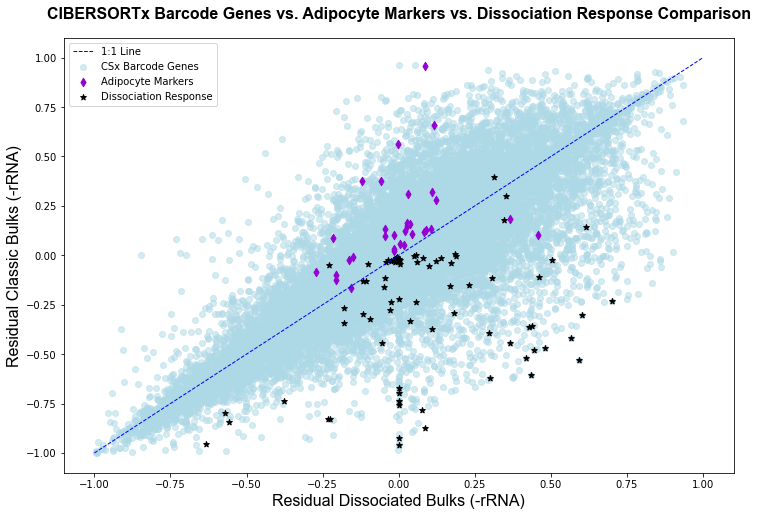

In [48]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(12, 8))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue',
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', 
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', 
                    label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('CIBERSORTx Barcode Genes vs. Adipocyte Markers vs. Dissociation Response Comparison', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=16, fontname='Arial')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=16, fontname='Arial')


# Add legend
plt.legend()

# Show the plot
plt.show()

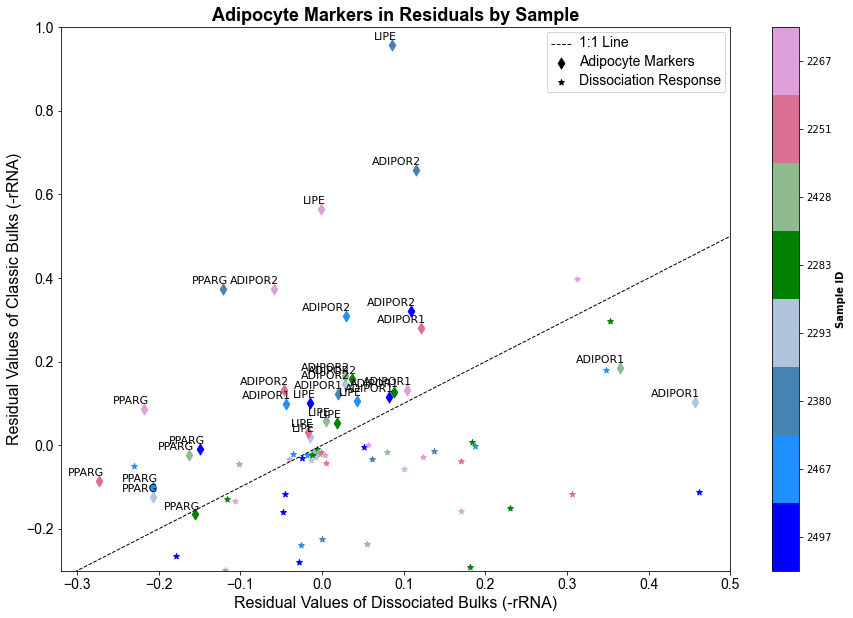

In [49]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=16, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=16, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


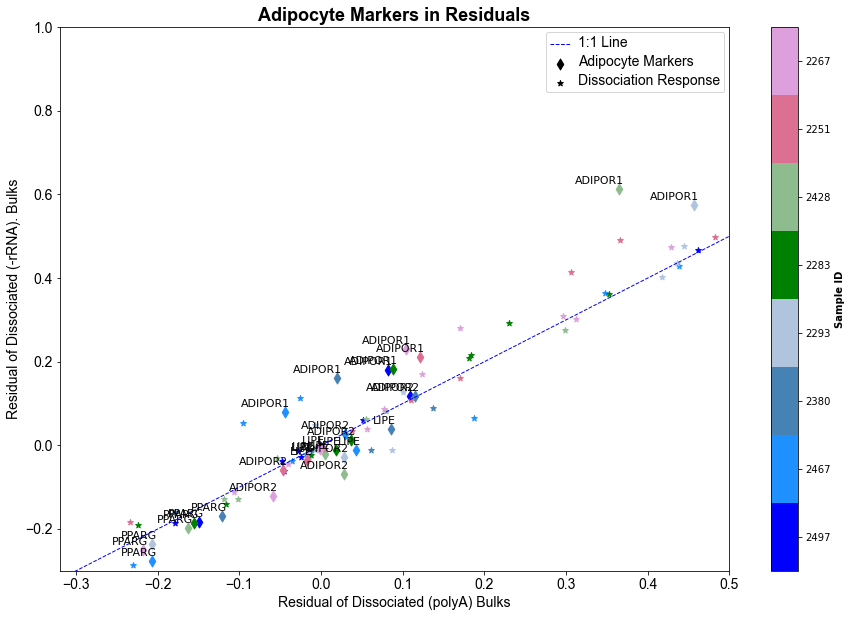

In [50]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_disspolyabulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual of Dissociated (-rRNA). Bulks', fontsize=14, fontname='Arial')
plt.xlabel('Residual of Dissociated (polyA) Bulks', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [51]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

,2497,2467,2380,2293,2283,2428,2251,2267
0,NBEAL2,AC136475.3,GPAM,NUP210,TTN,B4GALNT3,ITGB4,GPAM
1,CD163,MIRLET7BHG,LIPE,LY75,SRC,TSNARE1,NBEAL2,TTN
2,TTN,LY75,TTN,PTPRS,NBEAL2,CLCN5,PTPRF,PTPRF
3,DENND11,CIITA,PLXNA4,NBEAL2,CD163,TFCP2L1,MPEG1,ITPR3
4,TBC1D16,PVR,TNFSF14,NEO1,PLEKHG3,LDB1,TTN,PTPRS
5,SEC24C,TENM4,PTPRF,LAMA4,PPL,OTUD7B,WDFY4,NBEAL2
6,CD93,ARHGAP8,SLCO2B1,ITGB4,LAMB3,COL27A1,ITPR3,MUC16
7,NISCH,IKBKB,PPL,PSD4,CEP192,TMEM164,CIITA,COL27A1
8,CLSTN3,DENND11,AKR1C1,TMEM164,MYH14,NUP210,SEC24C,IL7R
9,PTPRS,NR2C2,STAT5A,TBCD,SDC1,ANPEP,NISCH,SLCO2B1


In [52]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

,2497,2467,2380,2293,2283,2428,2251,2267
0,NBEAL2,NBEAL2,PPL,TUFT1,TFCP2L1,TFCP2L1,TTN,NBEAL2
1,SEC24C,SEMA3B,TNFSF14,PSD4,LDB1,NECTIN4,NBEAL2,CP
2,MFSD2A,PTPRF,PTPRF,YOD1,NBEAL2,PSD4,ITGA3,PSD4
3,MAPK8IP3,ITGA3,SEMA3B,NBEAL2,SEMA7A,TUFT1,PTPRF,MUC16
4,ITPR3,MICAL1,ITPR3,NUP210,PLEKHG3,PLEKHG3,KLHL21,THSD4
5,ITGA3,ITPR3,ITGB4,LAMB3,KLHL21,PRSS22,FAM110C,CHI3L1
6,NISCH,SLC12A7,TTN,ITGA3,LAMB3,YOD1,SH3TC1,LTBP2
7,CLSTN3,TSC2,SLC12A7,SLC7A2,MYH14,PFKFB2,ITGB4,TTN
8,FLT1,CIC,ITGA3,LAMC2,RIPK4,ANPEP,ITPR3,ASS1
9,PTPRS,CIITA,LAMA3,HOMER2,VTCN1,CSF3R,LTBP2,ENPP2


# Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

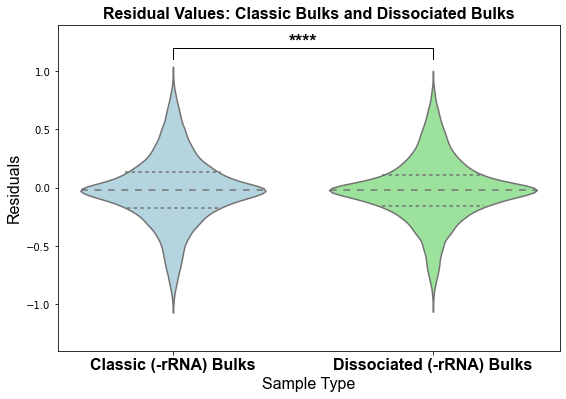

In [53]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1, 1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.5, .65, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

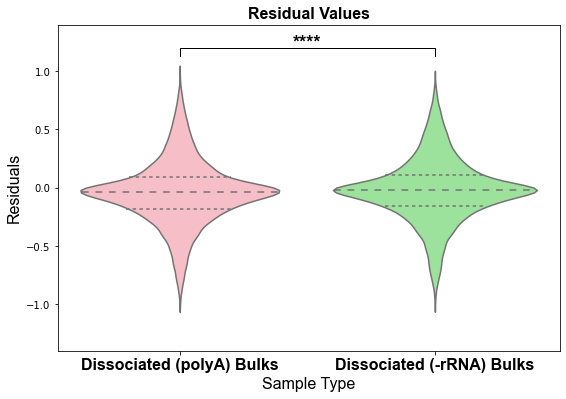

In [54]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results    
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, "N.S", ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

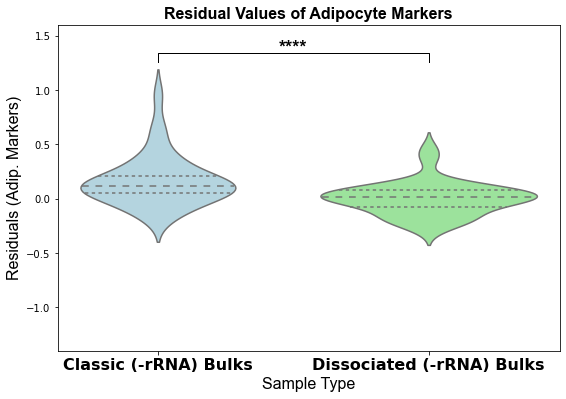

In [55]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

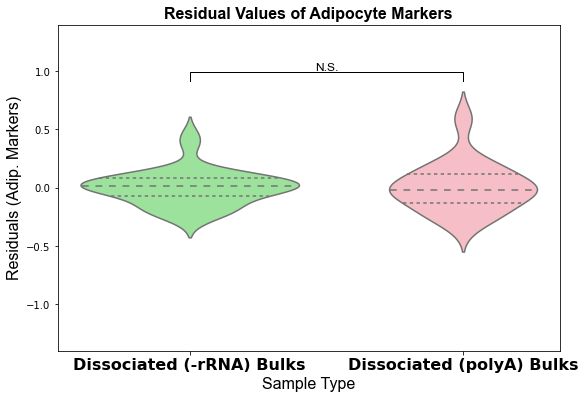

In [56]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

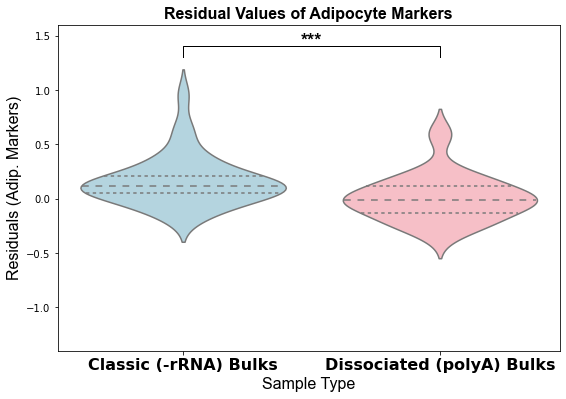

In [57]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

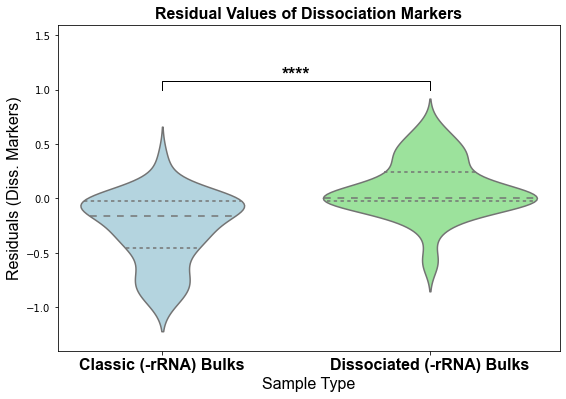

In [58]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


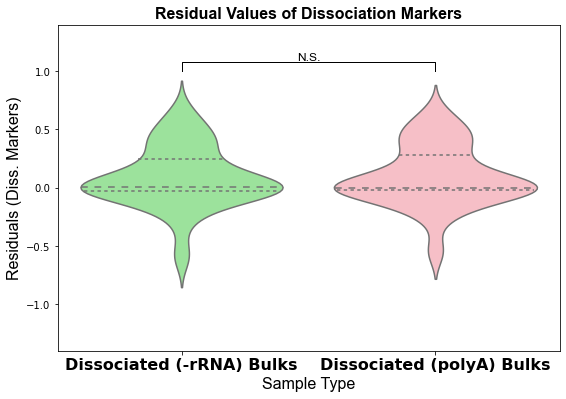

In [59]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

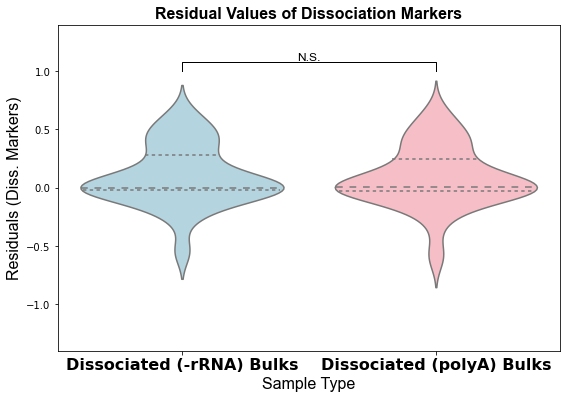

In [60]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

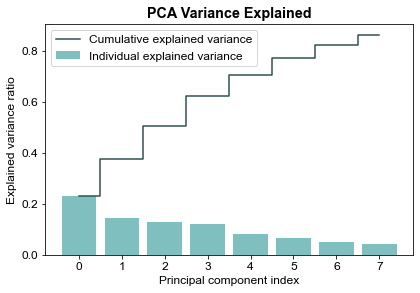

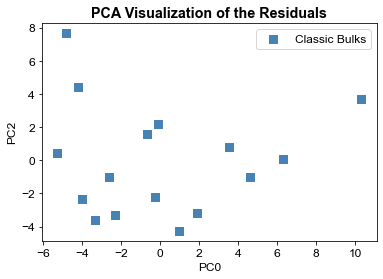

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7
0,VTCN1,LY75,GPAM,PPL,KIF26B,NAV2,CLDN1,EYA2
1,PELI2,BTN3A1,SAA1,DAPK1,INHBA,LAMA3,MYH11,RNF152
2,TTC28,CIITA,PLXNA4,KCNMA1,PDLIM3,AC136475.3,KCNMA1,ESR1
3,SPINT2,EHF,LIMCH1,SDC1,BHLHE41,RASSF8,IGLC1,SLC7A2
4,LGR4,BIRC3,TLN2,LAMA2,IGHG4,ARHGAP8,TNFSF10,CHST15
...,...,...,...,...,...,...,...,...
3740,CXCL8,B3GNT5,BGN,FBXO32,MECOM,NUP210,OSMR,SPINT2
3741,RND3,MFSD2A,AC253572.2,IGHG1,SLC16A1,PELI2,LAMC2,RHPN2
3742,CLDN1,ANKRD33B,AC245014.3,IGKC,CCL2,SESN3,STMN1,KLK7
3743,ZC3H12A,TFCP2L1,SMAD7,IFITM1,ADM,PGRMC1,ERAP2,ASS1


In [61]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [62]:
#and exporting PCA genes per component for gene ontology analysis.

''' NOTE: You'll need to run GOrilla on these lists for the next part!'''

pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "PCA_genes_residuals_combo.xlsx")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

In [63]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

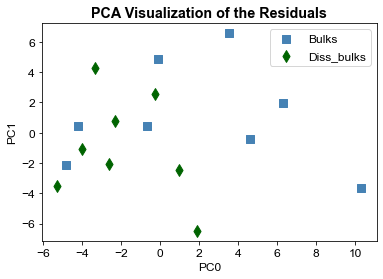

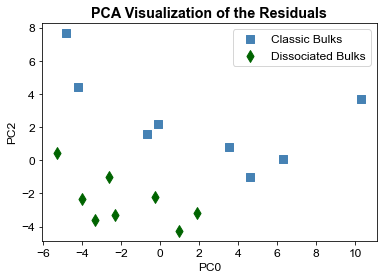

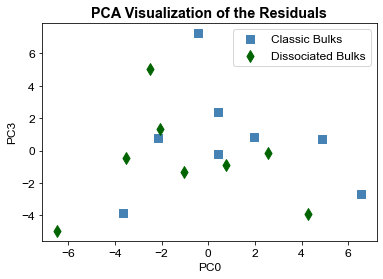

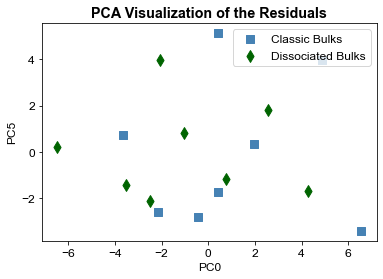

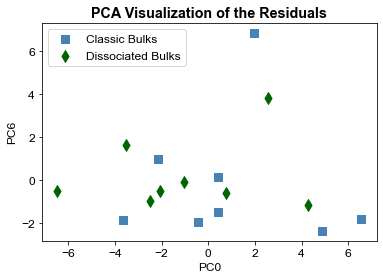

In [64]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



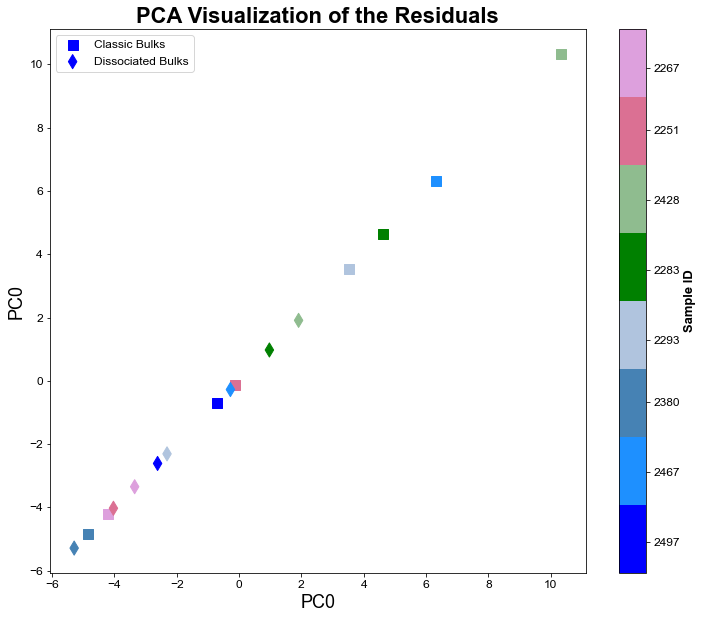

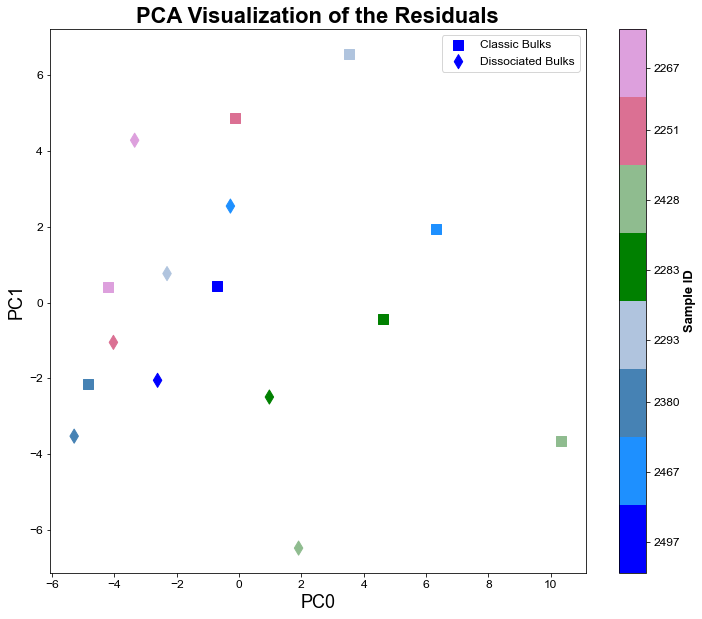

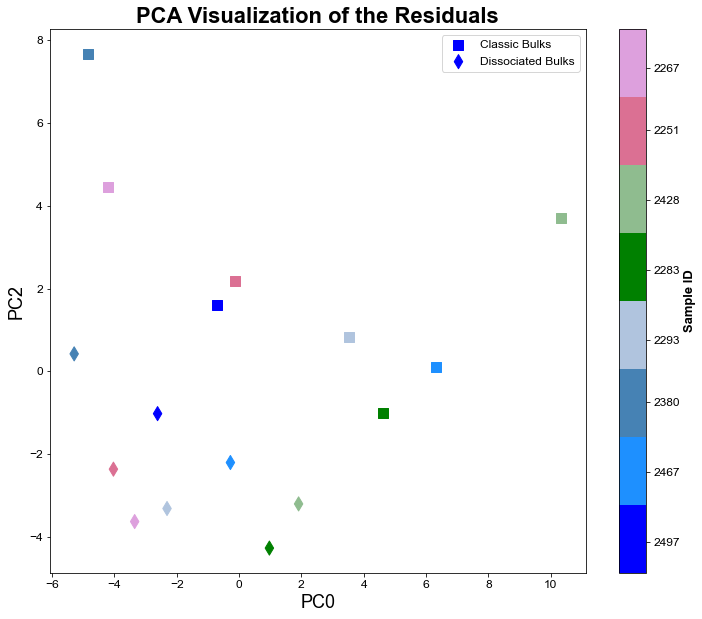

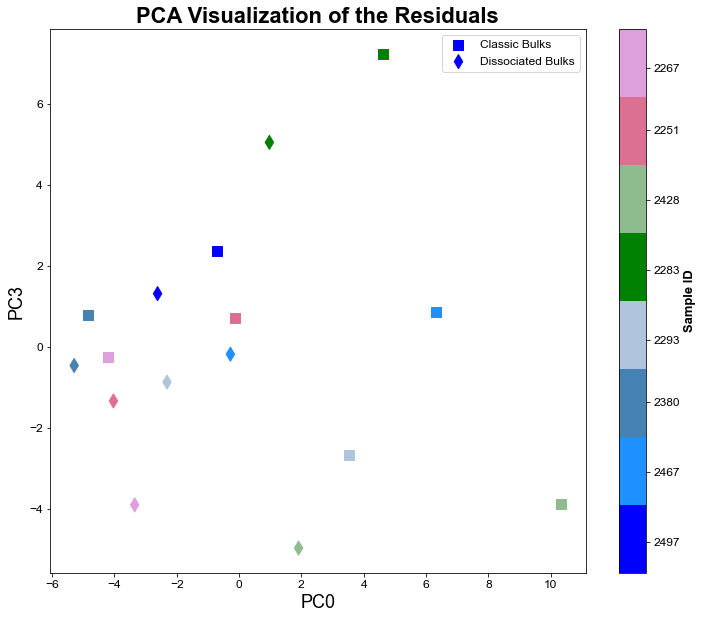

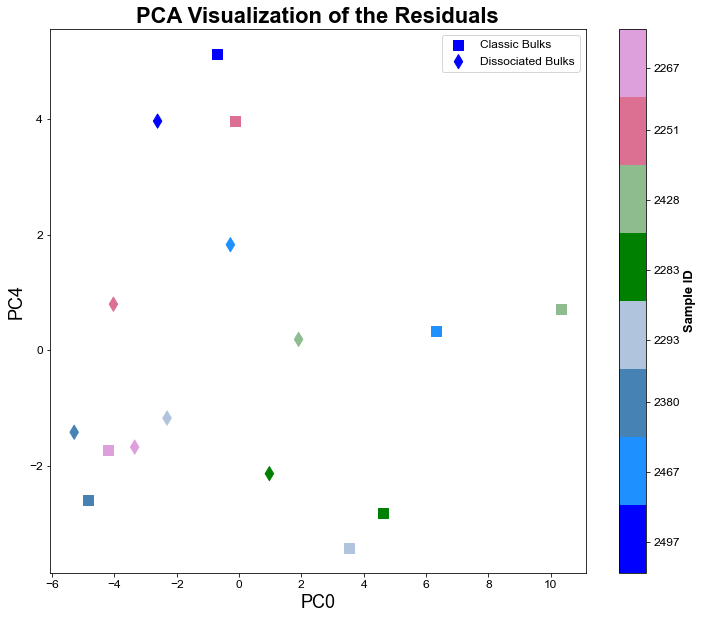

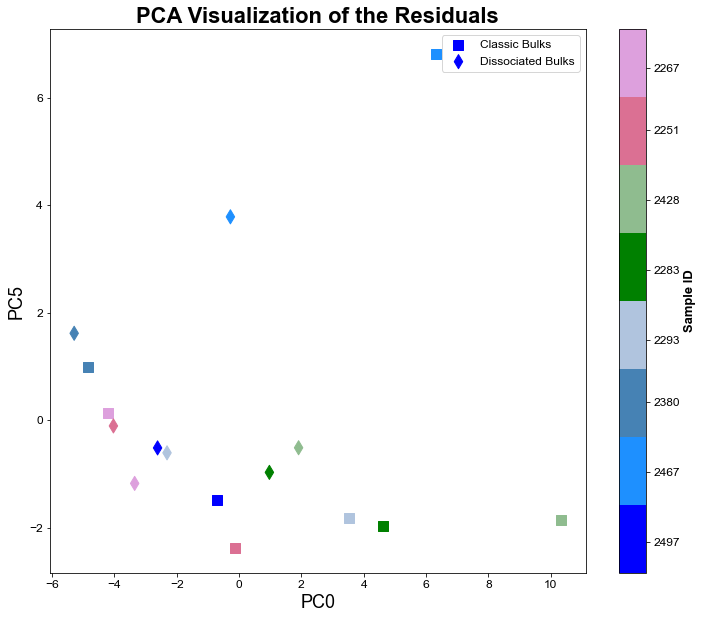

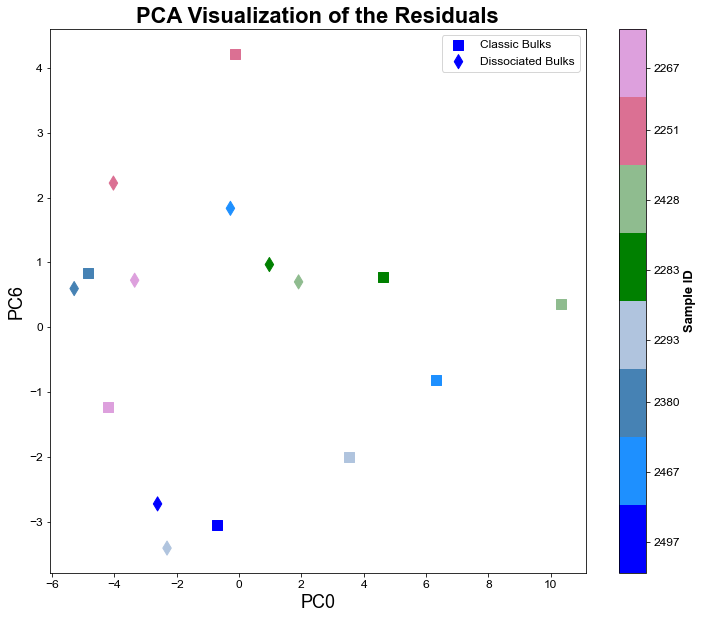

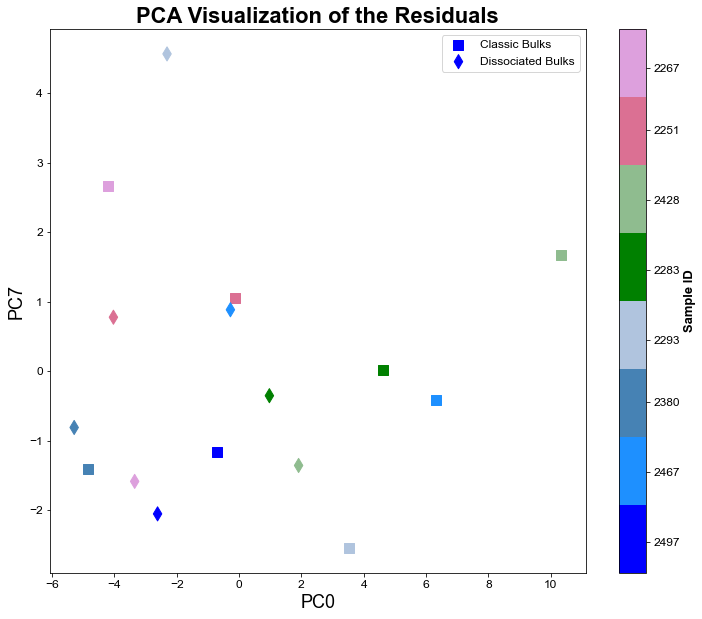

In [65]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (12,10))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 100

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)

    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=13, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids)

    # Change the color of the little marker in the legend
    # Change the color of the marker in the legend using a custom handler
    legend = plt.legend()

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=22, fontname='Arial')
    plt.xlabel("PC0", fontsize=18, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=18, fontname='Arial')
    plt.show()

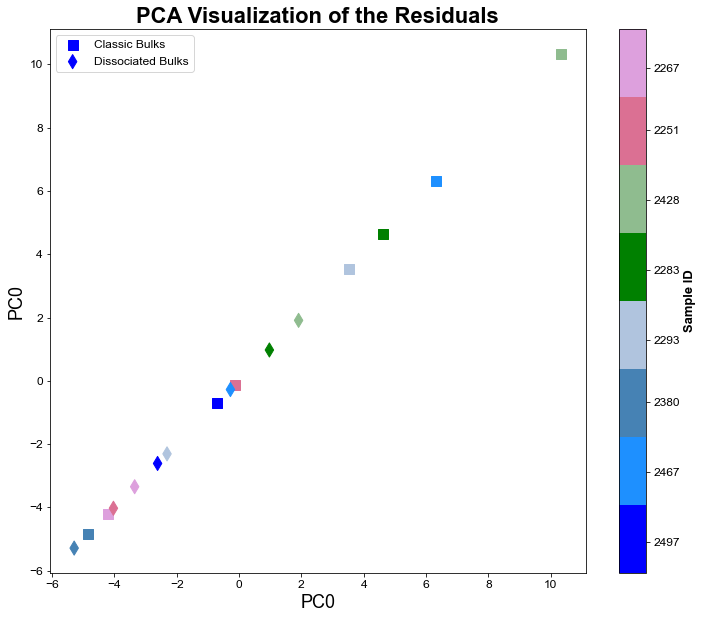

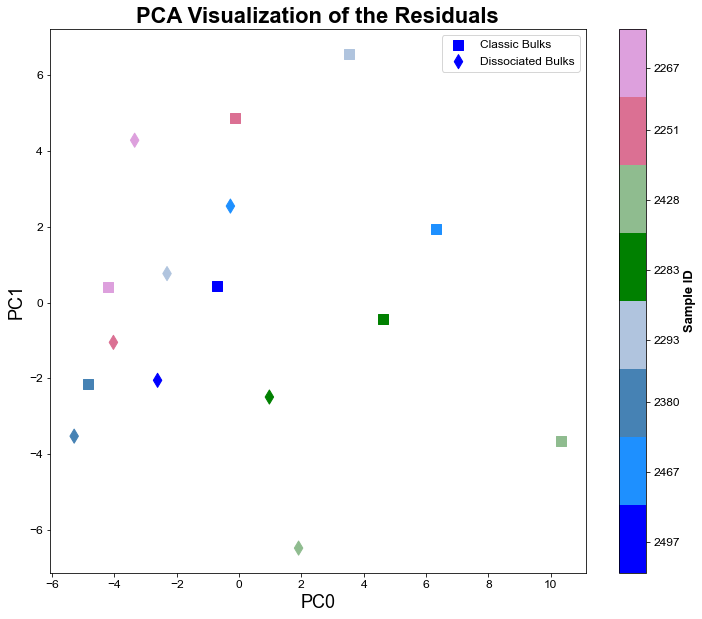

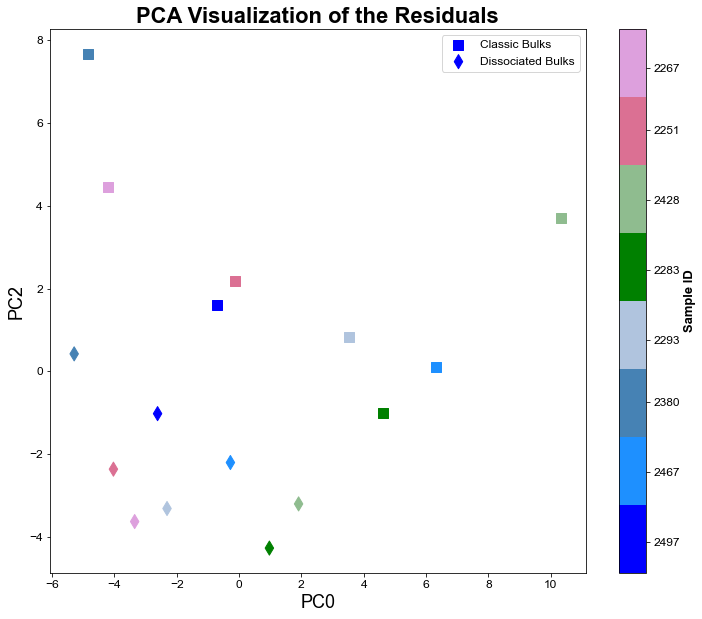

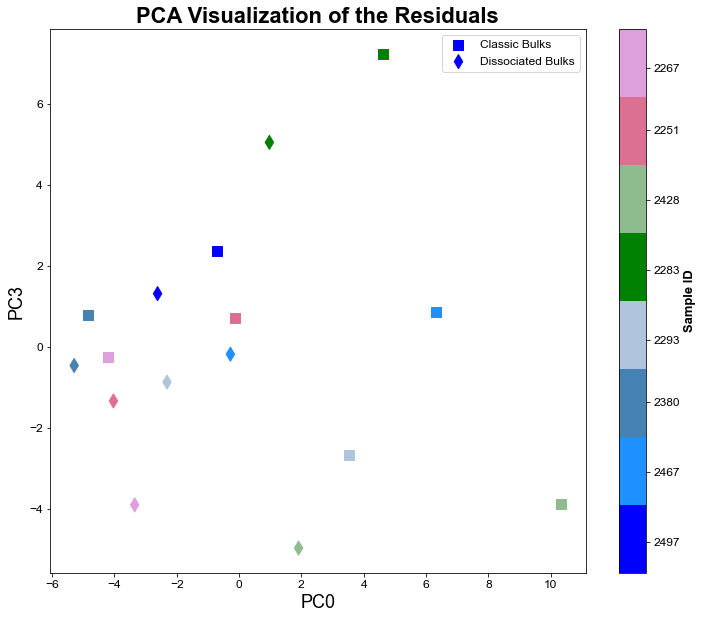

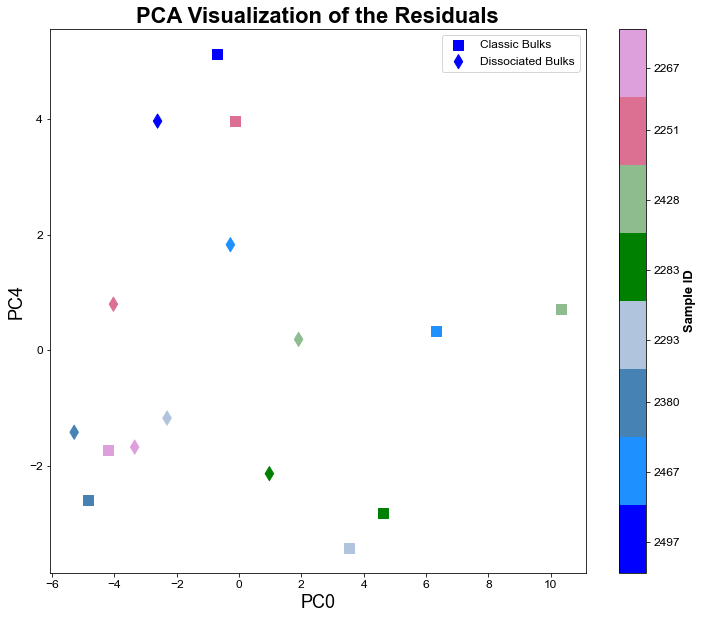

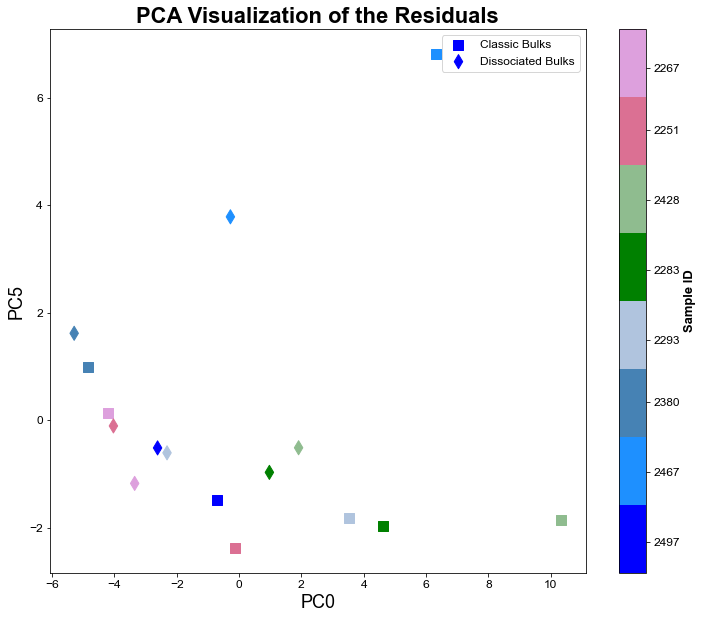

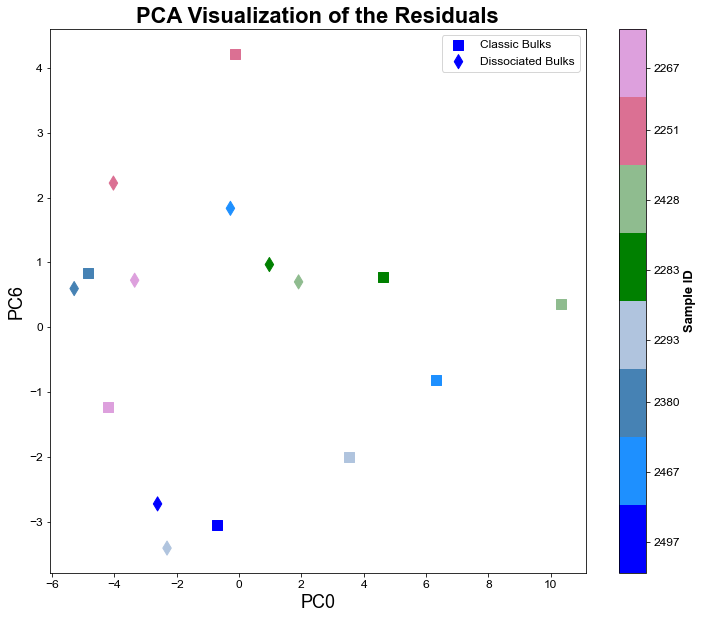

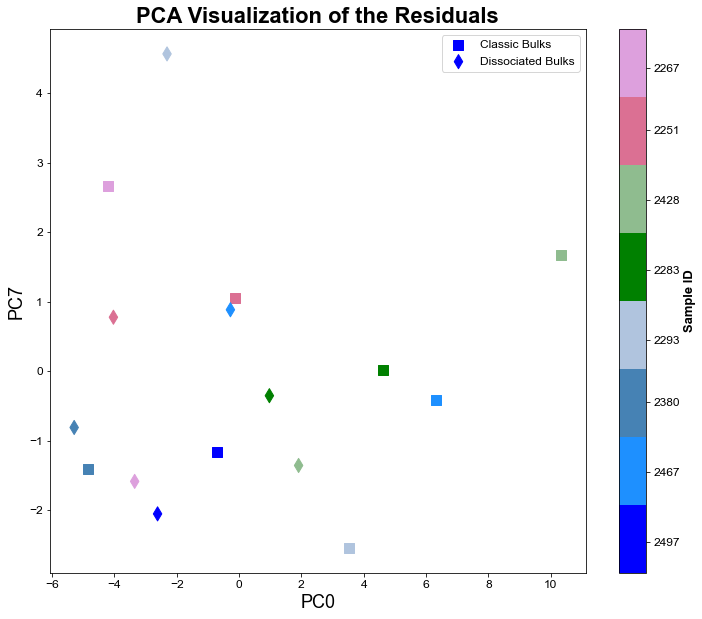

In [66]:
for idx in [0,1,2,3,4,5,6,7]:

    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (12,10))

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 100

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)

    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=13, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids)

    legend = plt.legend()

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=22, fontname='Arial')
    plt.xlabel("PC0", fontsize=18, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=18, fontname='Arial')
    plt.show()

In [67]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.812611  0.091386
1        1.0     1.166404  0.262937
2        2.0     4.373228  0.000637
3        3.0     0.817934  0.427097
4        4.0    -0.071765  0.943804
5        5.0    -0.311702  0.759860
6        6.0    -0.213337  0.834140
7        7.0    -0.023892  0.981276
Components with significantly different means:
   Component  T-Statistic   P-Value
2        2.0     4.373228  0.000637


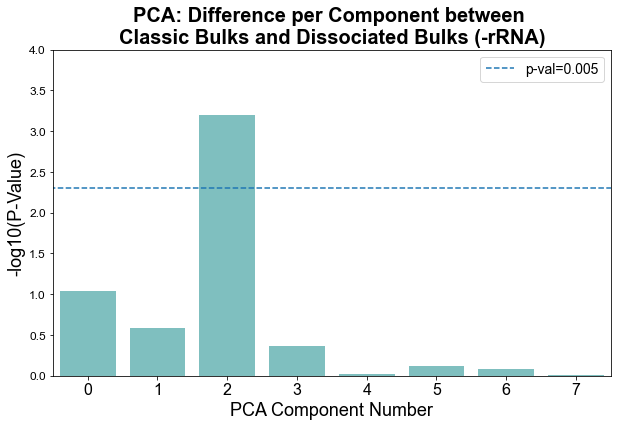

In [68]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('PCA Component Number', fontsize=18, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=18, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=20, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=16)
plt.ylim(0,4)
plt.legend(fontsize=14)
plt.xlim(-0.5,7.5)
plt.show()

And evaluating the GOrilla results (of combo residual):

In [69]:
''' NOTE: You'll need to run GOrilla on these lists for this part!'''

#For QC pre-plotting:
# Load the data from the Excel file
sheet_name = 'GOPROCESS_Component_2'  # Sheet name containing the relevant PCA component

# Reading the Excel sheet into a DataFrame
pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "GOPROCESS_PCA_genes_residuals_combo.xlsx")
data = pd.read_excel(pca_name_path, sheet_name=sheet_name)
#adding -log p value for plot
data["-logpvalue"] = -np.log10(data["P-value"])
data

,GO Term,Description,P-value,FDR q-value,Enrichment,N,B,n,b,Genes,-logpvalue
0,GO:0006641,triglyceride metabolic process,9.850000e-07,0.0106,7.06,3463,15,327,10,"[CAT - catalase, GK5 - glycerol kinase 5 (...",6.006564
1,GO:0006082,organic acid metabolic process,6.260000e-06,0.0337,1.54,3463,202,1010,91,"[CYP1B1 - cytochrome p450, family 1, subfami...",5.203426
2,GO:0034308,primary alcohol metabolic process,6.310000e-06,0.0227,128.26,3463,9,9,3,"[AKR1C1 - aldo-keto reductase family 1, memb...",5.199971
3,GO:0042572,retinol metabolic process,6.960000e-06,0.0188,61.84,3463,3,56,3,"[CYP1B1 - cytochrome p450, family 1, subfami...",5.157391
4,GO:0042574,retinal metabolic process,6.960000e-06,0.0150,61.84,3463,3,56,3,"[CYP1B1 - cytochrome p450, family 1, subfami...",5.157391
...,...,...,...,...,...,...,...,...,...,...,...
75,GO:0021644,vagus nerve morphogenesis,8.660000e-04,0.1230,1154.33,3463,1,3,1,[PLXNA4 - plexin a4],3.062482
76,GO:0048483,autonomic nervous system development,8.660000e-04,0.1210,1154.33,3463,1,3,1,[PLXNA4 - plexin a4],3.062482
77,GO:0080184,response to phenylpropanoid,9.010000e-04,0.1240,46.80,3463,2,74,2,"[CAT - catalase, EGFR - epidermal growth f...",3.045275
78,GO:0033194,response to hydroperoxide,9.340000e-04,0.1270,5.63,3463,9,410,6,[CD36 - cd36 molecule (thrombospondin recept...,3.029653


filtered: (19, 11)


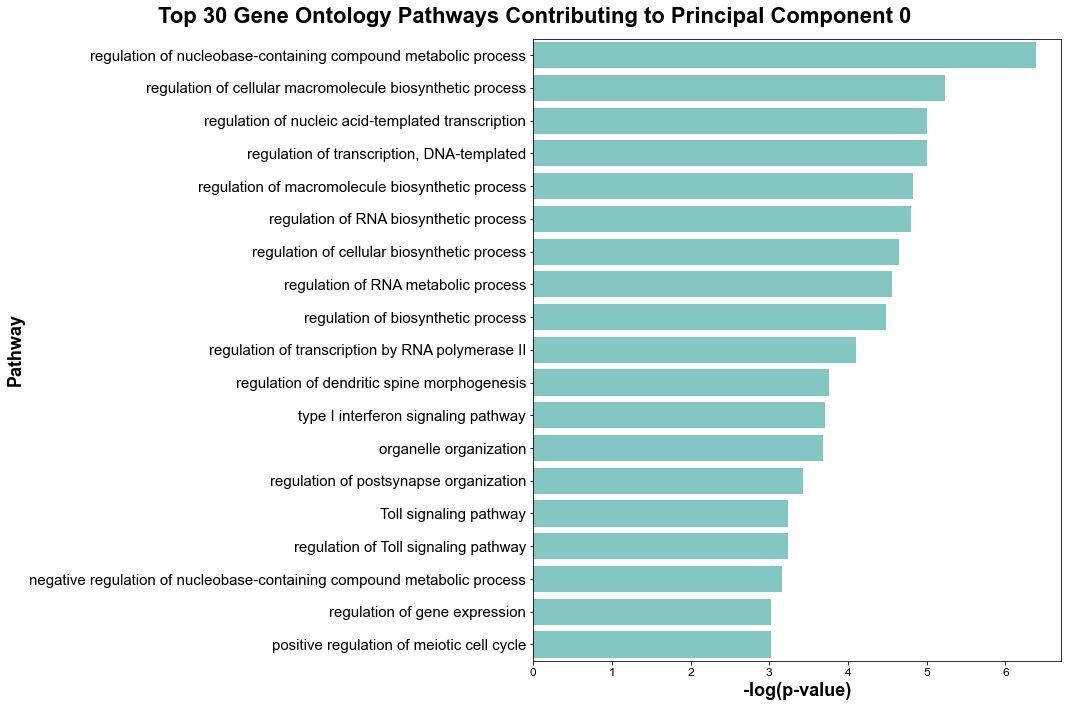

filtered: (30, 11)


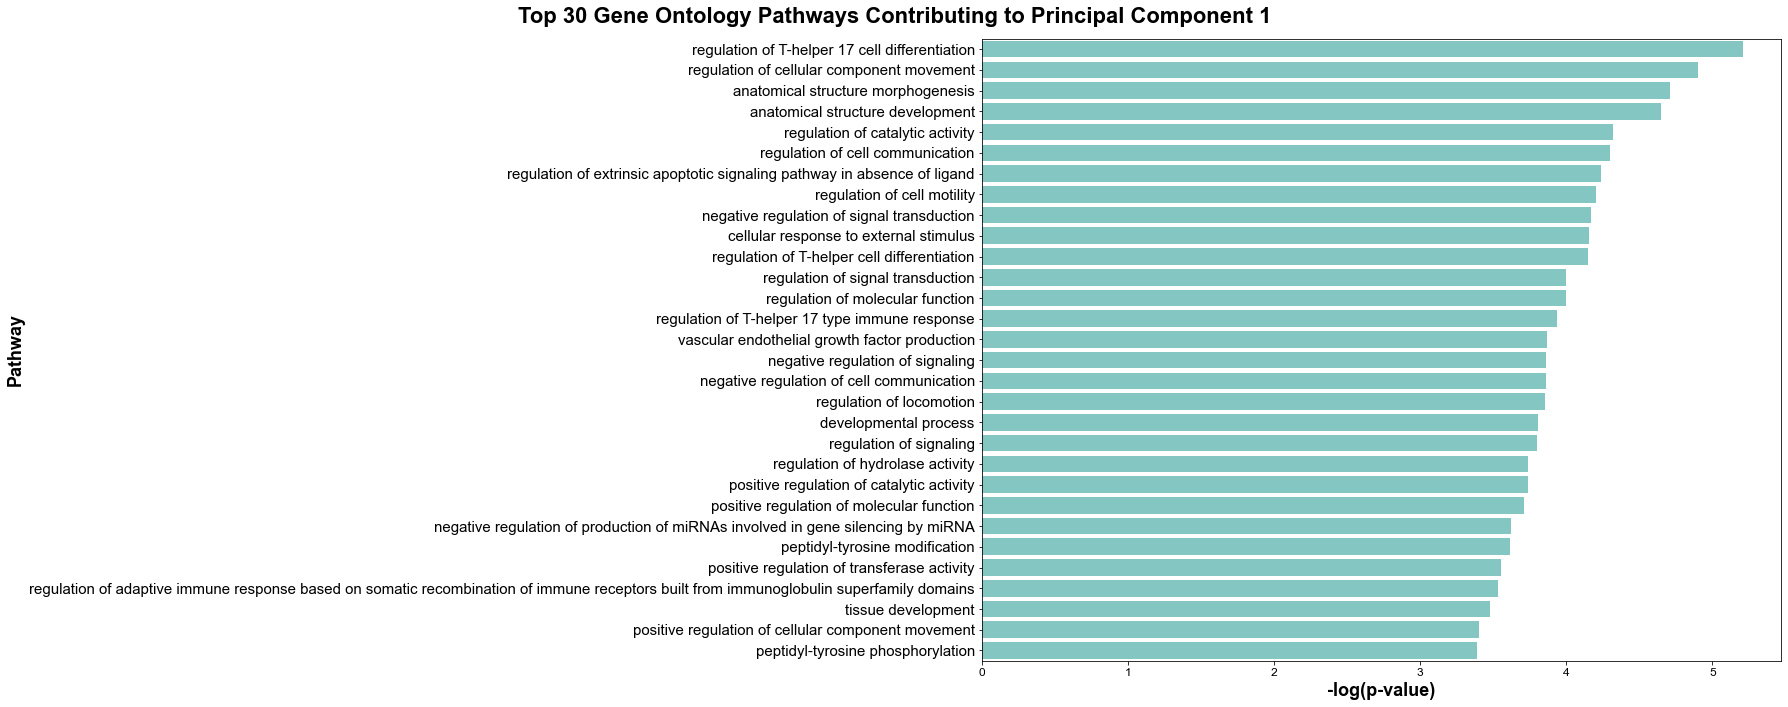

filtered: (30, 11)


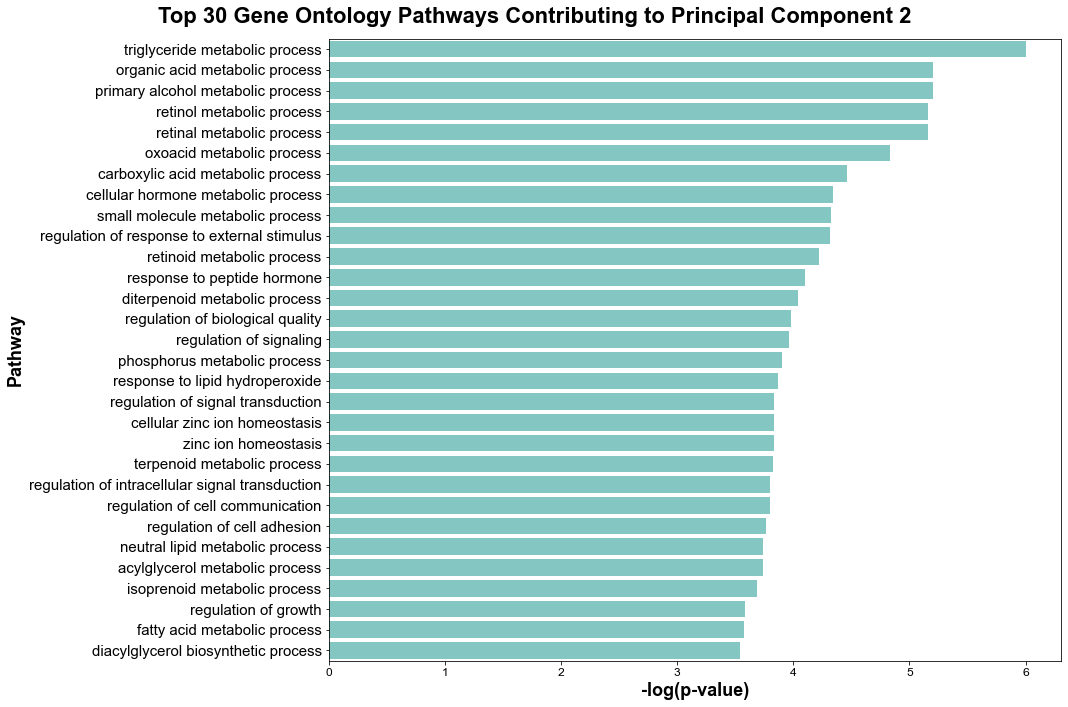

filtered: (30, 11)


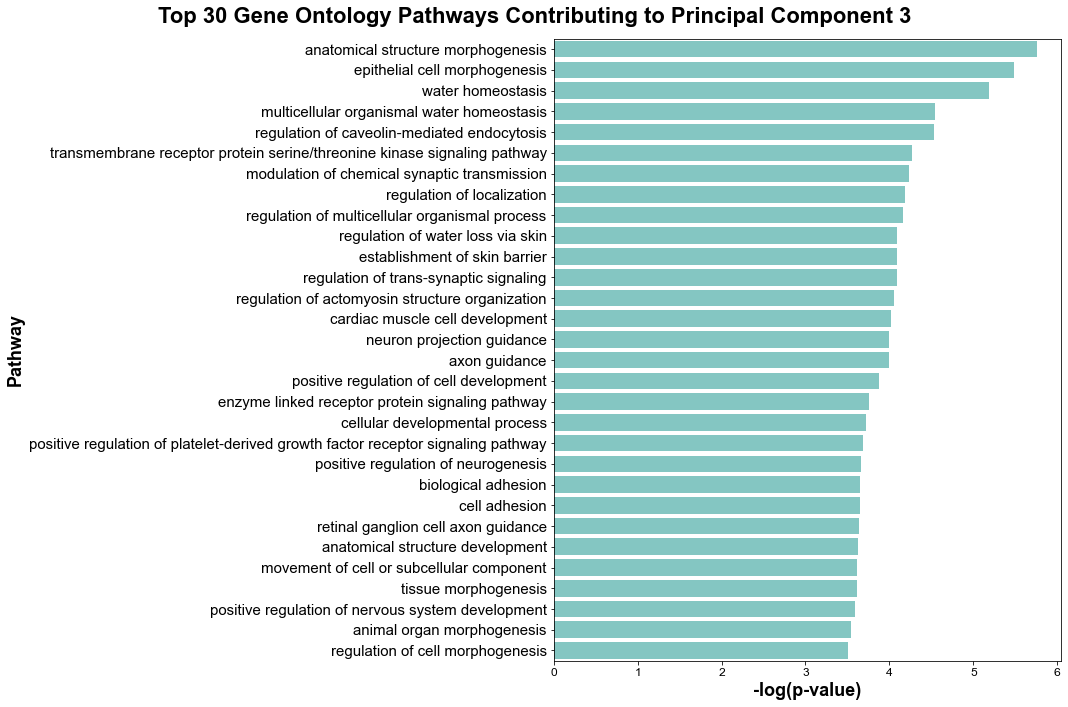

filtered: (30, 11)


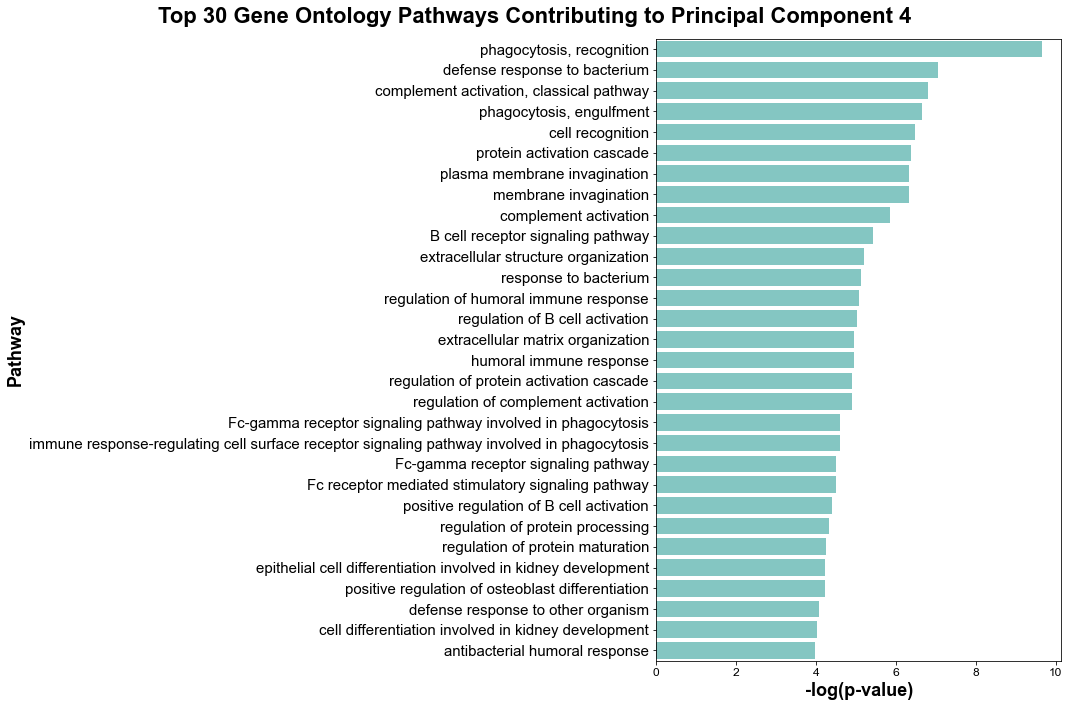

In [70]:
# The sheets on the Excel
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3', 'GOPROCESS_Component_4']
# Sheet name containing the relevant NMF component
figsizes = [(15,10),(25,10),(15,10),(15,10),(15,10)]
#for figure sized
num=0
for sheet_name in sheet_names:
    
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "GOPROCESS_PCA_genes_residuals_combo.xlsx")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # This assumes you have a column 'Pathway' containing the names of the pathways
    # and 'p-value' containing the p-values
    
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")

    # Plotting the data
    figure_size = figsizes[num]
    num = num+1
    plt.figure(figsize=figure_size)  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=18, fontweight='bold')
    plt.ylabel('Pathway', fontsize=18, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=22)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(15)

    plt.tight_layout()
    plt.show()

Classic Bulks (-rRNA)

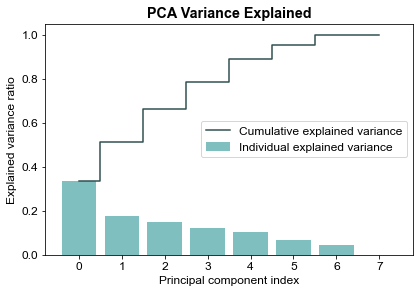

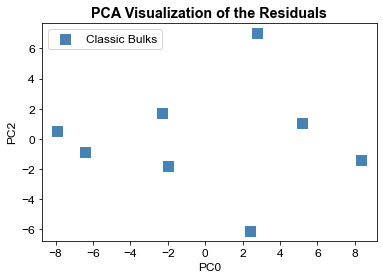

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7
0,PELI2,ANK2,KRT17,PTGDS,NNMT,CD36,CD24,ABCA1
1,VTCN1,CSF3R,CADM1,KIF26B,RASSF8,ADAMTS4,CHI3L1,AATK
2,H1F0,ADAMTS9,PPL,IGHG4,AC136475.3,MARCKSL1,SPP1,A1BG
3,TTC28,HSPA12A,KRT5,IGHM,IGHG1,STMN1,CR1,AASS
4,IFIT1,FAM107A,NHSL1,IGLC2,TENM4,RASGEF1B,COL27A1,AAGAB
...,...,...,...,...,...,...,...,...
3740,TAGLN,LY75,IGKC,LINC00511,RDX,KCNMA1,MYH11,EVA1B
3741,SAA1,HIST1H1E,SULF1,HK2,PVT1,RNASE1,CPM,CD163
3742,MGP,CFI,CCL2,MTHFD2,FAM110C,SLC1A3,PPL,LSM5
3743,CLDN1,CAPG,CHI3L1,ADM,IGF2BP2,CLDN1,KRT19,ABCA5


In [71]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_bulks  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()


# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes 

Dissociated (-rRNA) Bulks

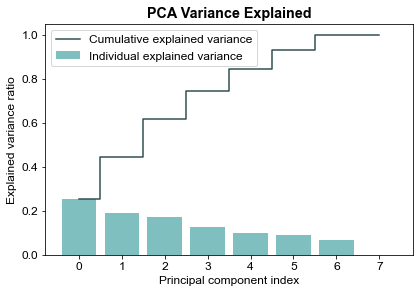

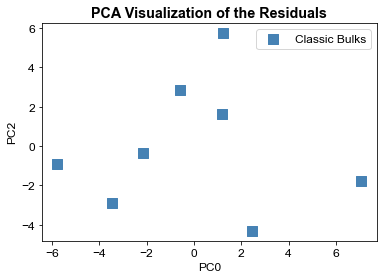

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7
0,TFCP2L1,CHI3L1,MT1M,KLK7,PDK4,PTGDS,IGLC1,A2M
1,FAM107A,TFPI2,ALDH1A3,KLK8,PAX8,STMN1,TEX14,AASS
2,MYH14,IGLC2,CCL2,FDFT1,HOMER2,CD24,IGLC3,ABCA5
3,PLAGL2,TCIM,SLC7A2,ARHGAP8,CD36,CTHRC1,IGHG4,AAGAB
4,RIPK4,IGHM,MT1A,DAPK1,ZNF91,INHBA,IGHG3,A1BG
...,...,...,...,...,...,...,...,...
3740,OLR1,MET,PTP4A3,G0S2,ITPKC,MECOM,LAMC2,TSC2
3741,CNN3,DAPK1,TFCP2L1,PMAIP1,SCPEP1,MUC1,BICDL1,ITGB4
3742,IGHA1,ITGA6,MECOM,THSD4,PVT1,LAMB3,TNFSF14,ALKBH7
3743,VCAM1,CLDN1,MDK,YOD1,CCND1,ESR1,SLC39A8,AATK


In [72]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_dissbulks  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()


# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes 

Dissociated (polyA) Bulks

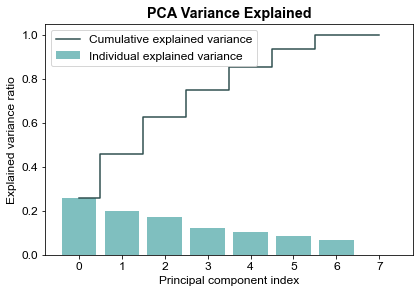

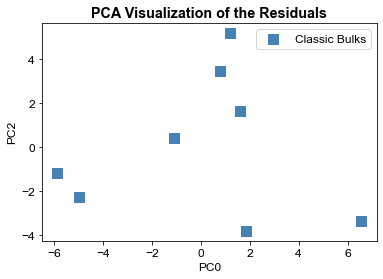

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7
0,FAM107A,CLDN1,MT1M,THSD4,PDK4,CD24,TRIM46,ABCA1
1,TFCP2L1,DAPK1,ALDH1A3,PTGS2,HOMER2,PTGDS,IGLC1,AATK
2,B3GNT5,SEMA3C,SLC7A2,YOD1,CD36,INHBA,IGHG3,AASS
3,MFSD2A,ITGA6,CCL2,EYA2,BHLHE41,PFKP,IGLC3,AAGAB
4,CRY2,PLAGL1,CLDN1,G0S2,ADAMTS9,CP,IGHM,SSB
...,...,...,...,...,...,...,...,...
3740,CCL4,DUSP4,CDC42BPA,NNMT,CCND1,KLK8,LAMA2,MGMT
3741,YAP1,TCIM,TFCP2L1,DAPK1,EHF,HIST2H2BE,THSD4,BASP1
3742,CIITA,IGHM,FOLR1,PHLDB2,ITPKC,LAMB3,IGFBP6,A1BG
3743,CAPG,IGLC2,ANGPT2,KLK8,FAM107A,ESR1,SLC39A8,A2M


In [73]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_disspolyabulks  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()


# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes 

## NMF

Analyzing how close to negative the distributions of each residual are:

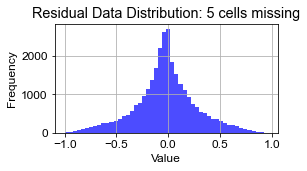

In [74]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

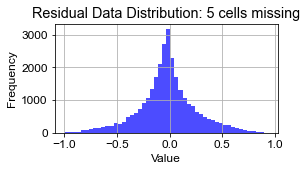

In [75]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9987755301954254


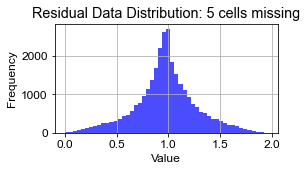

In [76]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9959977129788453


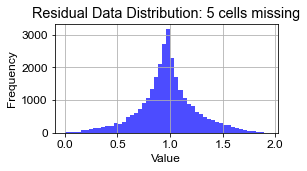

In [77]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9987755301954254


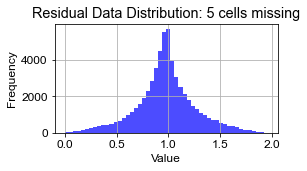

In [78]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [79]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.078082,0.154348,0.134056,0.140337,0.098999,0.143243,0.106561,0.133017,0.168870,0.151877,...,0.119146,0.050361,0.119337,0.091387,0.111914,0.119196,0.113768,0.126519,0.152262,0.166130
1,0.068465,0.171970,0.129413,0.119696,0.140654,0.156400,0.196878,0.114816,0.205902,0.108195,...,0.109987,0.040934,0.097376,0.073687,0.141986,0.127738,0.099279,0.148467,0.191920,0.054145
2,0.092551,0.129988,0.121294,0.145670,0.197525,0.142418,0.071317,0.122421,0.041158,0.059740,...,0.128721,0.045849,0.094645,0.100399,0.116861,0.268208,0.103191,0.150170,0.143062,0.198474
3,0.080213,0.143029,0.130918,0.163648,0.118907,0.141082,0.161276,0.113037,0.129051,0.152344,...,0.115503,0.021180,0.100692,0.085413,0.129705,0.142754,0.097780,0.123542,0.131498,0.129348


In [95]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.048559  9.619569e-01
1        1.0     0.891231  3.878660e-01
2        2.0    -9.121834  2.880155e-07
3        3.0     0.875751  3.959426e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -9.121834  2.880155e-07


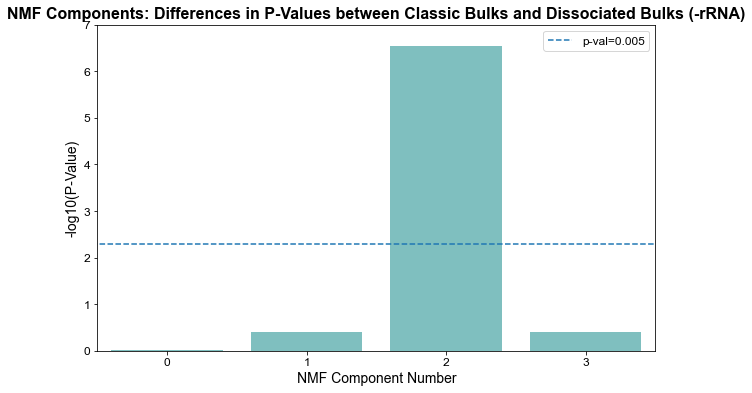

In [81]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
plt.title('NMF Components: Differences in P-Values between Classic Bulks and Dissociated Bulks (-rRNA)', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3])
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend()
plt.show()

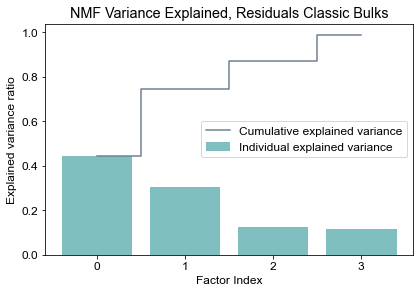

In [83]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [84]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

,Component_0,Component_1,Component_2,Component_3
0,LY75,VTCN1,NLRP3,TLN2
1,CIITA,PTPRS,KRT17,PLXNA4
2,TAP2,NR2C2,KLHL21,GPAM
3,BTN3A1,PLEKHG3,DUSP2,TTN
4,TTN,LGR4,EPHA2,TBC1D16
...,...,...,...,...
3740,ANKRD33B,AREG,PSMB9,PMAIP1
3741,MT1A,CCL2,ADIRF,HIST1H1D
3742,CFD,HSPA1A,IGHA1,TEX14
3743,MT1M,CXCL8,SELENOP,MDK


And plotting gene ontology analysis pathways.

NOTE: You'll have to run GOrilla for this part!

In [ ]:
#Exporting NMF genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "NMF_genes_residuals_combo.xlsx")
nmf_genes_combo.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

In [ ]:
''' NOTE: You'll need to run GOrilla on these lists for this part!'''

# Load the data from the Excel file
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3']
                # Sheet name containing the relevant NMF component

for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "GOPROCESS_NMF_genes_residuals_combo.xlsx")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    # Filter the DataFrame for pathways related to adipocyte functions
    # This assumes you have a column 'Pathway' containing the names of the pathways
    # and 'p-value' containing the p-values
    data["-logpvalue"] = -np.log10(data["P-value"])
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")

    # Plotting the data
    plt.figure(figsize=(15, 10))  # Adjust size as needed
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=18, fontweight='bold')
    plt.ylabel('Pathway', fontsize=18, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways in Factor {sheet_name[-1]}', fontname = 'Arial',fontweight='bold', fontsize=22)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(15)

    plt.tight_layout()
    plt.show()

### Dissociated bulks:

In [85]:
#nmf on residual 1
num_nmf = 5
nmf = NMF(n_components = num_nmf, init="nndsvd", max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_dissbulks_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_dissbulks = res_nmf_df
components_dissbulks = pd.DataFrame(nmf.components_)
components_dissbulks.columns = gene_ids
components_dissbulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.084538,0.178725,0.151695,0.160228,0.144279,0.172524,0.140570,0.137837,0.146888,0.111623,...,0.131872,0.054228,0.112472,0.100298,0.153063,0.215573,0.121662,0.171375,0.188962,0.136441
1,0.061619,0.116609,0.090243,0.087509,0.166087,0.109519,0.132824,0.087483,0.123381,0.079984,...,0.088760,0.023373,0.073036,0.064691,0.087511,0.133660,0.071448,0.098933,0.144939,0.075577
2,0.038838,0.074510,0.063060,0.068430,0.051990,0.071889,0.048659,0.055853,0.056791,0.067141,...,0.059577,0.015027,0.053208,0.045249,0.059853,0.098086,0.052023,0.050303,0.059105,0.076527
3,0.079814,0.126467,0.118665,0.148142,0.143256,0.130594,0.122329,0.111334,0.122138,0.108762,...,0.119210,0.033953,0.094347,0.079700,0.113260,0.143408,0.092306,0.120686,0.127011,0.160284
4,0.065178,0.093562,0.082271,0.108106,0.096940,0.094370,0.103906,0.096702,0.087988,0.107878,...,0.079829,0.030797,0.085813,0.066437,0.077444,0.063416,0.074753,0.100880,0.108582,0.138513


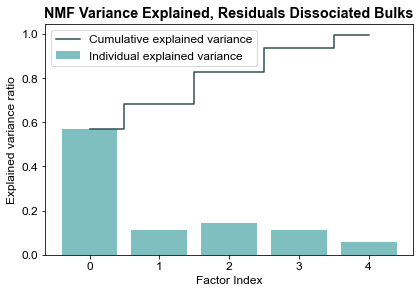

In [86]:
# W and H are your NMF results
V = residuals_dissbulks_shift.values
W = res_nmf_dissbulks.values
H = components_dissbulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Dissociated Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [87]:
W = res_nmf_dissbulks.values
H = components_dissbulks.values

nmf_genes_dissbulks = pd.DataFrame()
num_components = 5

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_dissbulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_dissbulks[component_idx] = top_genes[::-1]
nmf_genes_dissbulks.columns = range(1,num_components+1)   
nmf_genes_dissbulks

,1,2,3,4,5
0,LDB1,NECTIN4,THSD4,SLC7A2,KLK7
1,NBEAL2,CSF3R,CHI3L1,ITGB4,SLCO2B1
2,SEC24C,SCARA3,CSF1,MFSD2A,MICAL1
3,NISCH,SPHK1,NUP210,PPL,CIITA
4,PTPRS,AC116366.1,PSD4,S1PR1,FDFT1
...,...,...,...,...,...
3740,IGLC2,COX17,MGP,EVA1B,MT1A
3741,MT1M,EIF5B,WFDC2,CCL3,CFD
3742,ADIRF,DYNLL1,MT1M,ATP5MC1,RPL22L1
3743,IGLC3,HIST1H4C,SPINT2,ADIRF,PRDX2


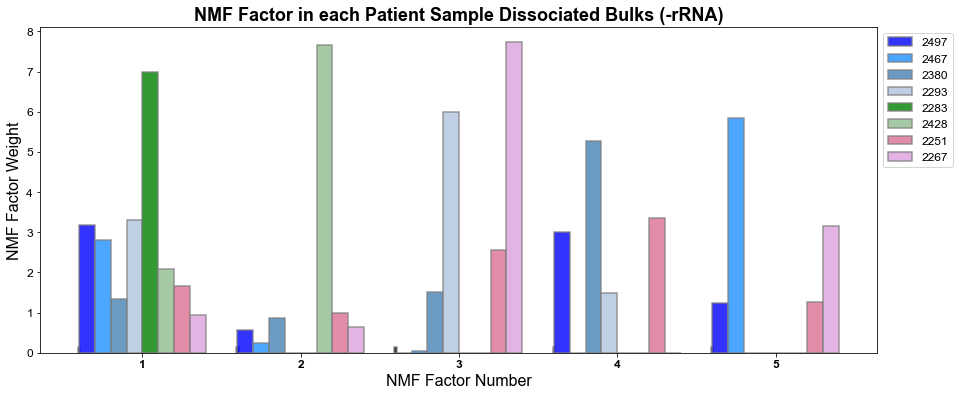

In [88]:
pt1_values = res_nmf_dissbulks.loc[0].values
pt2_values = res_nmf_dissbulks.loc[1].values
pt3_values = res_nmf_dissbulks.loc[2].values
pt4_values = res_nmf_dissbulks.loc[3].values
pt5_values = res_nmf_dissbulks.loc[4].values
pt6_values = res_nmf_dissbulks.loc[5].values
pt7_values = res_nmf_dissbulks.loc[6].values
pt8_values = res_nmf_dissbulks.loc[7].values

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

sample_and_type = sample_ids

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.8, color='black', 
                edgecolor='grey', linewidth=1.5)

plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[0], color=custom_colors[0], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[1], color=custom_colors[1], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[2], color=custom_colors[2], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[3], color=custom_colors[3], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[4], color=custom_colors[4], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[5], color=custom_colors[5], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[6], color=custom_colors[6], edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[7], color=custom_colors[7], edgecolor='grey', linewidth=1.5)


plt.xlabel('NMF Factor Number', fontsize=16)
plt.ylabel('NMF Factor Weight', fontsize=16)

# Set the title to bold
plt.title('NMF Factor in each Patient Sample Dissociated Bulks (-rRNA)', fontweight='bold', fontsize=18)

plt.xticks(x_coordinates, fontweight='bold')  # Adjust x-axis labels

# Move the legend to the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

plt.show()

### Classic Bulks

In [89]:
#NMF Residual(by sample) of bulks
num_nmf = 5
nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
res_nmf_df = nmf.fit_transform(residuals_bulks_shift)
components_bulks = nmf.components_
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_bulks = res_nmf_df
components_bulks = pd.DataFrame(components_bulks)
components_bulks.columns = gene_ids
components_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.067956,0.152104,0.124990,0.119231,0.119906,0.141154,0.126184,0.112260,0.202305,0.145925,...,0.108911,0.041569,0.102970,0.076398,0.108913,0.118954,0.099979,0.093674,0.164705,0.101418
1,0.073958,0.122163,0.115501,0.147930,0.103540,0.125474,0.132108,0.096829,0.090313,0.139300,...,0.099093,0.014161,0.087255,0.077402,0.114711,0.146993,0.086312,0.106146,0.106452,0.110469
2,0.044759,0.114508,0.078883,0.075373,0.088711,0.103313,0.155607,0.073175,0.131862,0.072495,...,0.071631,0.021630,0.064838,0.047814,0.100906,0.081397,0.061861,0.091457,0.127499,0.035430
3,0.058310,0.131182,0.110458,0.104800,0.104183,0.125571,0.107224,0.095048,0.144803,0.073341,...,0.088728,0.041591,0.076583,0.059263,0.107051,0.111934,0.084709,0.136870,0.133147,0.056141
4,0.069159,0.123498,0.110666,0.128245,0.104032,0.109730,0.111200,0.120633,0.091733,0.102179,...,0.110114,0.036080,0.098539,0.087316,0.096796,0.115194,0.092856,0.139304,0.125527,0.189718


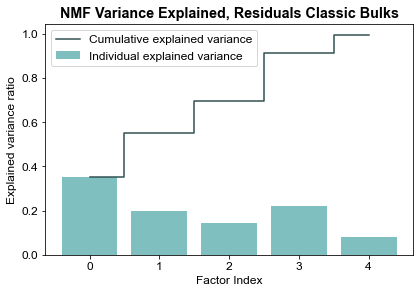

In [90]:
# W and H are your NMF results
V = residuals_bulks_shift.values
W = res_nmf_bulks.values
H = components_bulks.values 

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [91]:
W = res_nmf_bulks.values
H = components_bulks.values

nmf_genes_bulks = pd.DataFrame()
num_components = 5

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_bulks[component_idx] = top_genes[::-1]
nmf_genes_bulks.columns = ["Component_0","Component_1","Component_2","Component_3",
                        "Component_4"]
nmf_genes_bulks

,Component_0,Component_1,Component_2,Component_3,Component_4
0,LY75,GPAM,B4GALNT3,PPL,RASSF2
1,TAP2,PLXNA4,TSNARE1,LAMB3,THEMIS2
2,TBCD,SAA1,GLI3,CEP192,PDLIM3
3,CIITA,LIPE,CLCN5,LAMA3,ANKH
4,ERAP2,TLN2,TFCP2L1,CD163,IL7R
...,...,...,...,...,...
3740,IGLC3,TCF7L2,IGHA1,IGLC1,G0S2
3741,IGHM,H1F0,IGLC1,IGLC2,MT1A
3742,MGP,TEX14,AREG,IGLC3,ADM
3743,PTGDS,PSMB9,HSPA1A,CCL2,TEX14


In [92]:
#and exporting PCA genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "NMF_genes_residuals_bulks.xlsx")
nmf_genes_bulks.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

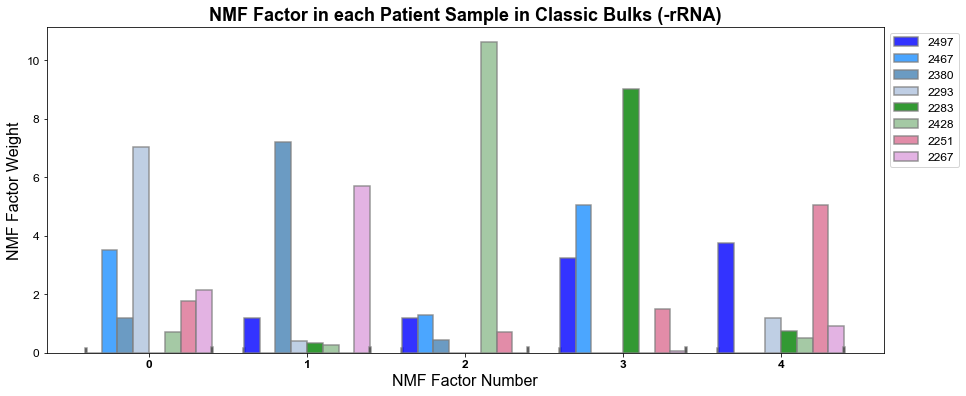

In [93]:
pt1_values = res_nmf_bulks.loc[0].values
pt2_values = res_nmf_bulks.loc[1].values
pt3_values = res_nmf_bulks.loc[2].values
pt4_values = res_nmf_bulks.loc[3].values
pt5_values = res_nmf_bulks.loc[4].values
pt6_values = res_nmf_bulks.loc[5].values
pt7_values = res_nmf_bulks.loc[6].values
pt8_values = res_nmf_bulks.loc[7].values

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) 

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

sample_and_type = sample_ids
# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.8, color='black', 
                edgecolor='grey', linewidth=1.5)
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[0], color=custom_colors[0], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[1], color=custom_colors[1], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[2], color=custom_colors[2], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[3], color=custom_colors[3], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[4], color=custom_colors[4], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[5], color=custom_colors[5], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[6], color=custom_colors[6], edgecolor='grey', linewidth=1.5)

# Plot "ociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.8, 
                label=sample_and_type[7], color=custom_colors[7], edgecolor='grey', linewidth=1.5)

plt.bar(x_coordinates + (bar_width * 4), 0.2, width=0.015, alpha=0.8, color='black', 
                edgecolor='grey', linewidth=1.5)

plt.xlabel('NMF Factor Number', fontsize=16)
plt.ylabel('NMF Factor Weight', fontsize=16)

# Set the title to bold
plt.title('NMF Factor in each Patient Sample in Classic Bulks (-rRNA)', fontweight='bold', fontsize=18)

plt.xticks(x_coordinates, fontweight='bold')  # Adjust x-axis labels

# Move the legend to the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

plt.show()

filtered: (30, 11)


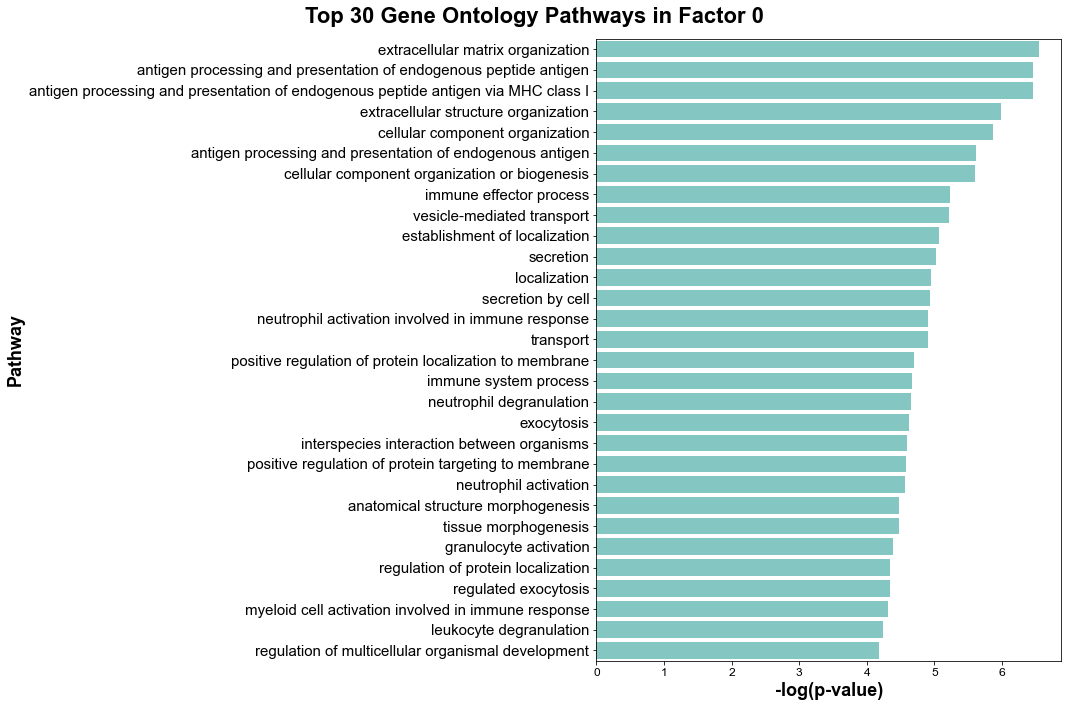

filtered: (30, 11)


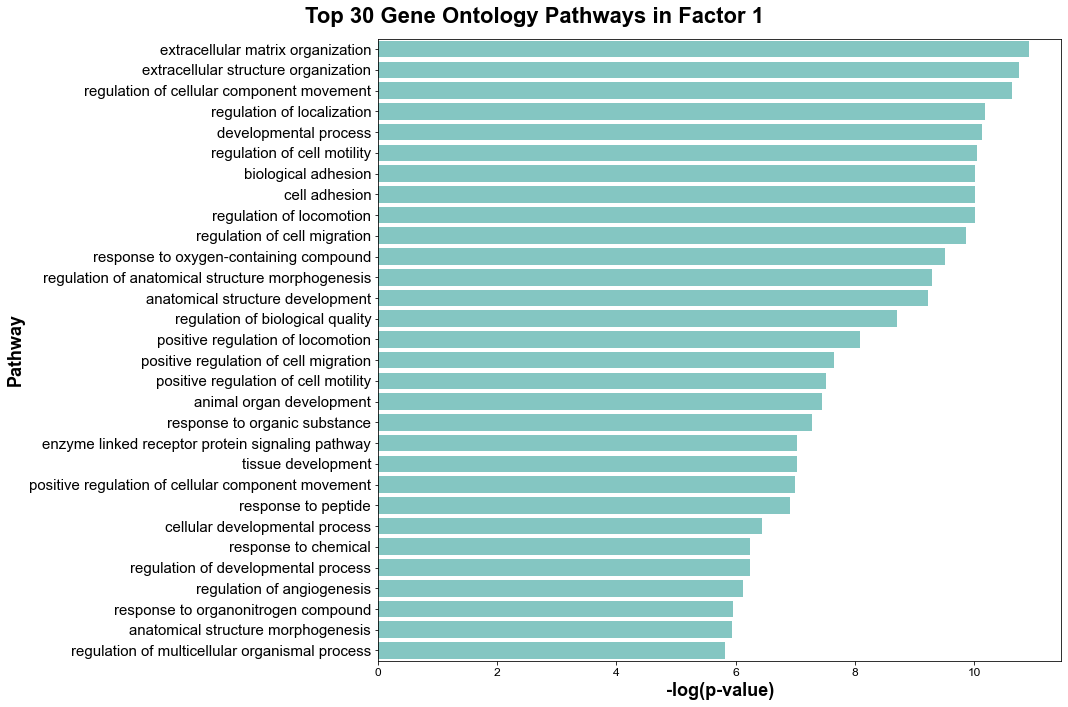

filtered: (8, 11)


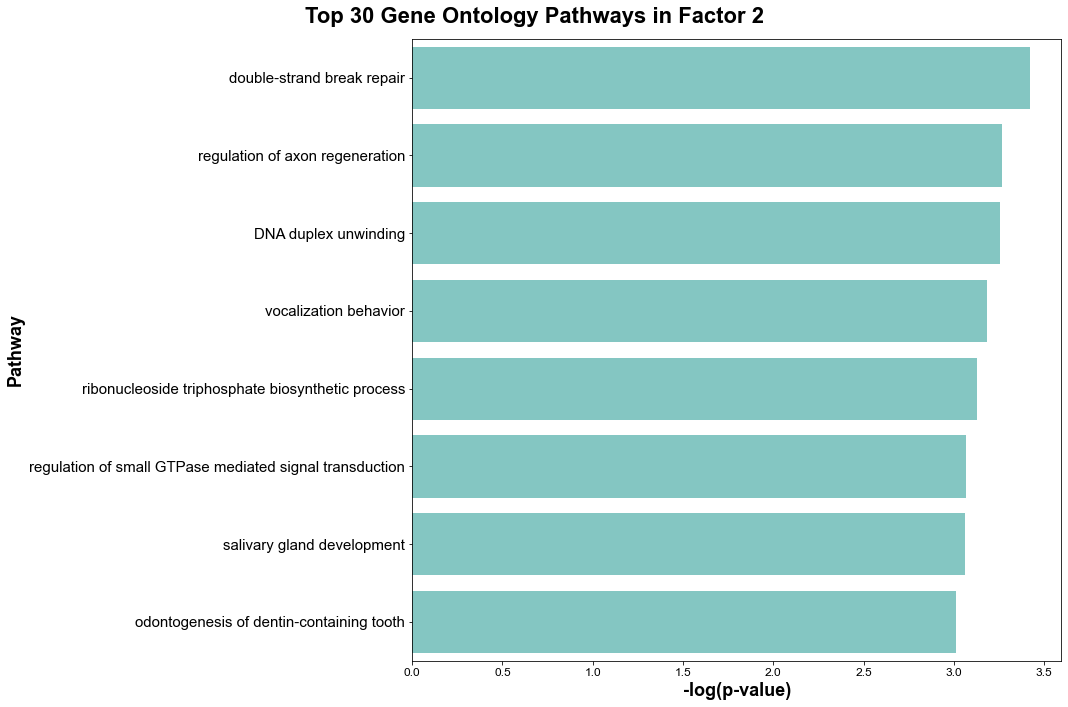

filtered: (30, 11)


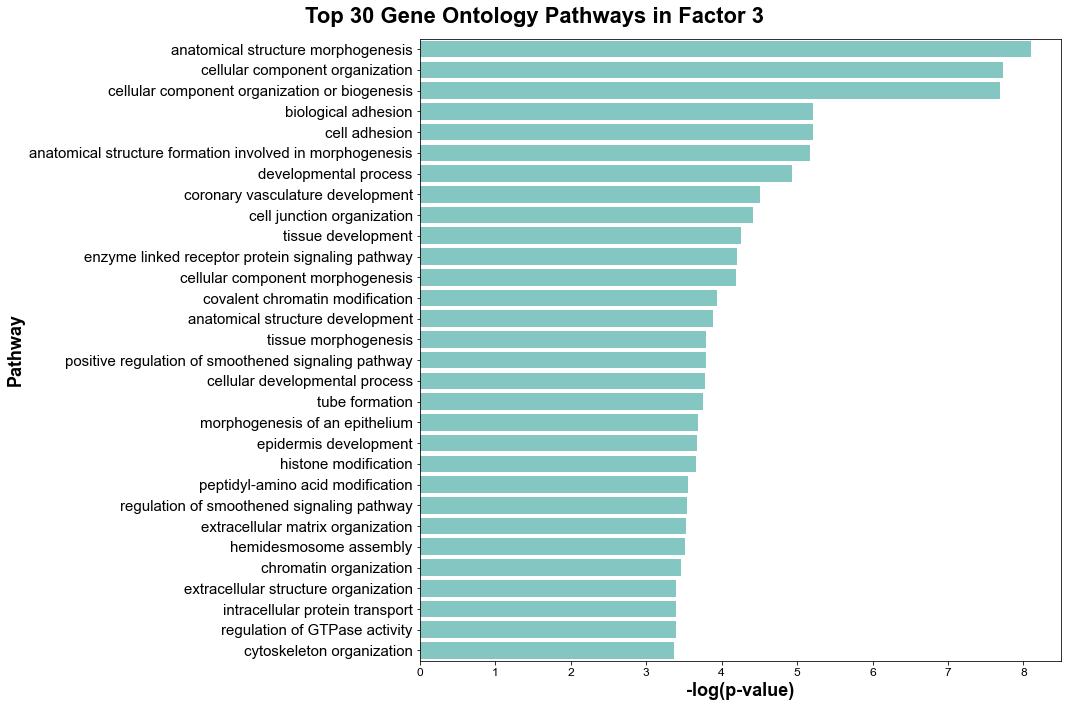

filtered: (30, 11)


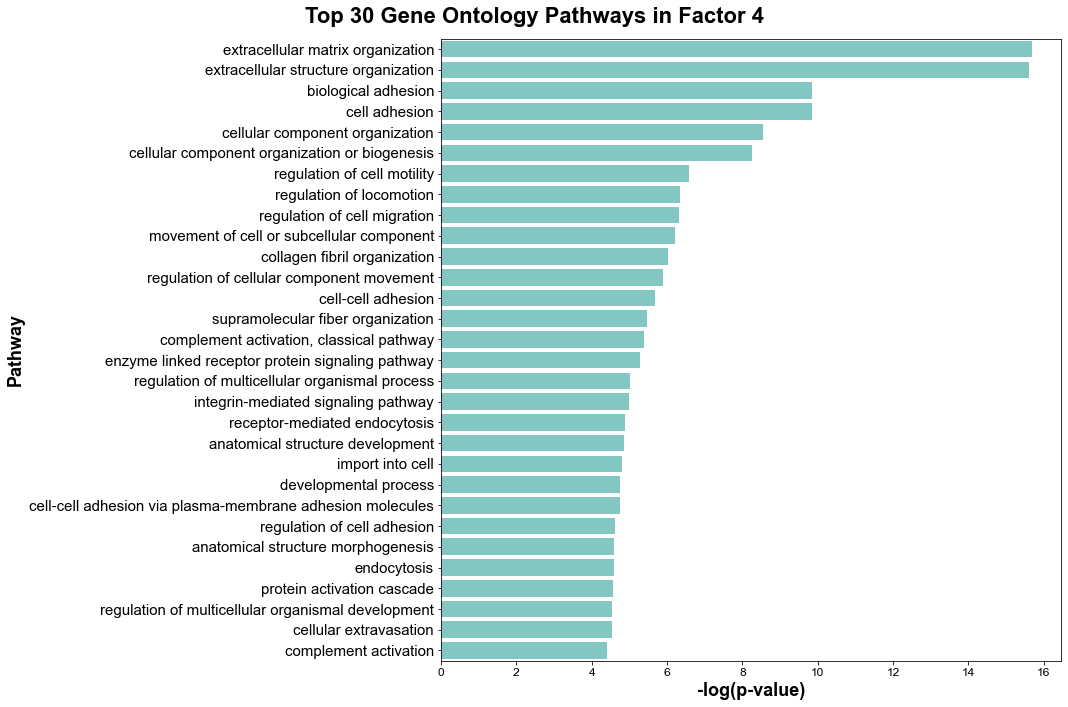

In [94]:
# Load the data from the Excel file
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3', 'GOPROCESS_Component_4']
                # Sheet name containing the relevant NMF component

for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", "GOPROCESS_NMF_genes_residuals_classic.xlsx")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    # This assumes you have a column 'Pathway' containing the names of the pathways
    # and 'P-value' containing the p-values
    data["-logpvalue"] = -np.log10( data["P-value"] )
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")

    # Plotting the data
    plt.figure(figsize=(15, 10))  # Adjust size 
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=18, fontweight='bold')
    plt.ylabel('Pathway', fontsize=18, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways in Factor {sheet_name[-1]}', fontname = 'Arial',fontweight='bold', fontsize=22)
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(15)

    plt.tight_layout()
    plt.show()